<div style="text-align: right"> Update date: Dec 4, 2023 </div><br>

# Detection of inefficiencies in solar plant<br>

This case study simulates that we will be working for a photovoltaic solar energy generation company.

They have detected anomalous behavior in 2 of the plants and the maintenance area is not able to identify the reason.

Before deploying a team of engineers, management has commissioned the preparation of a analyze the data from the sensors and meters to see if the problem can be detected.<br><br>

## Business Analytcs<br>
### Objetive<br>

Analyze the available data to detect photovoltaic solar energy generation problems and whether or not it is necessary to transport a team of engineers to the plants.<br><br>

### Levers<br>
**How does a photovoltaic solar power plant work?**

<img src="./media/How_Solar_Power_Works.png">

Chart source: https://upload.wikimedia.org/wikipedia/commons/b/bb/How_Solar_Power_Works.png

Therefore, the levers that influence the business objective (in this case generating AC current) are:

1. **Irradiation**: the greater the irradiation, the greater the DC generated. But it is not monotonic (_when a function increases throughout its domain or decreases throughout its domain_), from certain values higher temperature can reduce the generation capacity.
2. **State of the panels**: they must be clean and functioning correctly to generate the greatest possible DC energy.
3. **Efficiency of inverters**: there is always a loss in the transformation from DC to AC, but it should be as minimal as possible. They must also be in correct condition and functioning.
4. **Meters and sensors**: if they break down and do not measure well, we lose traceability and the possibility of detecting failures.<br><br>

### Key Performance Indicator(KPI)<br>

* Irradiation: measures the solar energy that arrives.
* Ambient and module temperature: measured by the plant sensors in degrees Celsius.
* DC power: measured in direct current kW.
* AC power: measured in alternating current kW.
* Inverter efficiency (we will create it): measures the transformation capacity from DC to AC. Calculated as AC/DC * 100<br><br>

### Entities and data<br>

The solar plant is made up of:

* Cell: It is the minimum unit where energy generation occurs by reaction with the sun's photons.
* Module: The cells are encapsulated in "rectangles" that are called modules.
* Panel: Several modules form a panel.
* Arrays: The panels are organized in rows called arrays.
* Inverter: An inverter receives direct current from several arrays.
* A plant can have several inverters.
* There are also meters and sensors, which may be one or more.

<img src="./media/sun_panels.jpeg">

In our case, the granularity of the entities that we have in the data are:
 
* 15 minute windows over a 34 day period
* Plants: there are 2
* Inverters: several per plant
* Only one irradiation sensor per plant
* Only one room temperature sensor per plant
* Only one temperature sensor module per plant

This means that we will be able to know, for example, if an inverter in a plant has lower performance than expected, but we will not know which array, panel or module may be causing it.<br><br>

### **Seed questions**<br>

About irradiation:

* Is there enough irradiation every day?
* Is it similar in both plants?
* How is your distribution per hour?
* How is it related to ambient temperature and module temperature?

About the plants:

* Does the same amount of irradiation reach them?
* Do you have a similar number of inverters?
* Do they generate a similar amount of DC?
* Do they generate a similar amount of AC?

About the DC generation:

* What is the relationship between irradiation and DC generation?
* Is it ever affected by ambient or module temperature?
* Is it similar in both plants?
* How is it distributed throughout the day?
* Is it constant throughout the days?
* Is it constant in all inverters?
* Have there been moments of failure?

About AC generation:

* What is the relationship between DC and AC generation?
* Is it similar in both plants?
* How is it distributed throughout the day?
* Is it constant throughout the days?
* Is it constant in all inverters?
* Have there been moments of failure?

About meters and sensors:

* Are the irradiation data reliable?
* Is the temperature data reliable?
* Is DC data reliable?
* Is AC data reliable?
* Are the data similar between both plants?

<br>
<br>

### The general outline of this notebook is as follows:
1. Load data
2. Prepare variables
3. Update datamart
4. Analysis and insights
5. Communication of results

<br>

### Main work tools<br>

|Package|                           Version|
|:---------------------------------|--------:|
|matplotlib                        | 3.8.0|
|numpy                             | 1.25.2|
|notebook                          |6.5.4|
|pandas                            | 2.1.1|
|python                            |3.10.12|
|seaborn                           | 0.13.0|


### Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config IPCompleter.greedy = True

#Pandas options
pd.options.display.max_columns = None
pd.options.display.float_format = '{:15.2f}'.format

print('Imported libraries')

Imported libraries


### Load data

These data sources were explored, cleaned and transformed to select the data necessary to integrate the datamart, which was stored in a pickle format. Specific details can be consulted in the corresponding [Exploratory Data Analysis](https://github.com/ACCpath/ExploratoryDataAnalysis/blob/main/DetectionInefficienciesSolarPlant/detection_inefficiencies_solar_plant_EDA.ipynb) directory.

Connect to data source

In [2]:
df = pd.read_pickle('data/df.pickle')
df

plant      inverter_id           kw_dc           kw_ac  \
date_time                                                                    
2020-05-15 00:00:00    p1  1BY6WEcLGh8j5v7            0.00            0.00   
2020-05-15 00:00:00    p1  1IF53ai7Xc0U56Y            0.00            0.00   
2020-05-15 00:00:00    p1  3PZuoBAID5Wc2HD            0.00            0.00   
2020-05-15 00:00:00    p1  7JYdWkrLSPkdwr4            0.00            0.00   
2020-05-15 00:00:00    p1  McdE0feGgRqW7Ca            0.00            0.00   
...                   ...              ...             ...             ...   
2020-06-17 23:45:00    p2  q49J1IKaHRwDQnt            0.00            0.00   
2020-06-17 23:45:00    p2  rrq4fwE8jgrTyWY            0.00            0.00   
2020-06-17 23:45:00    p2  vOuJvMaM2sgwLmb            0.00            0.00   
2020-06-17 23:45:00    p2  xMbIugepa2P7lBB            0.00            0.00   
2020-06-17 23:45:00    p2  xoJJ8DcxJEcupym            0.00            0.00   

                             kw_day        kw_total        sensor_id  \
date_time                                                              
2020-05-15 00:00:00            0.00      6259559.00  HmiyD2TTLFNqkNe   
2020-05-15 00:00:00            0.00      6183645.00  HmiyD2TTLFNqkNe   
2020-05-15 00:00:00            0.00      6987759.00  HmiyD2TTLFNqkNe   
2020-05-15 00:00:00            0.00      7602960.00  HmiyD2TTLFNqkNe   
2020-05-15 00:00:00            0.00      7158964.00  HmiyD2TTLFNqkNe   
...                             ...             ...              ...   
2020-06-17 23:45:00         4157.00       520758.00  iq8k7ZNt4Mwm3w0   
2020-06-17 23:45:00         3931.00    121131356.00  iq8k7ZNt4Mwm3w0   
2020-06-17 23:45:00         4322.00      2427691.00  iq8k7ZNt4Mwm3w0   
2020-06-17 23:45:00         4218.00    106896394.00  iq8k7ZNt4Mwm3w0   
2020-06-17 23:45:00         4316.00    209335741.00  iq8k7ZNt4Mwm3w0   

                     ambient_temperature  module_temperature     irradiation  
date_time                                                                     
2020-05-15 00:00:00                25.18               22.86            0.00  
2020-05-15 00:00:00                25.18               22.86            0.00  
2020-05-15 00:00:00                25.18               22.86            0.00  
2020-05-15 00:00:00                25.18               22.86            0.00  
2020-05-15 00:00:00                25.18               22.86            0.00  
...                                  ...                 ...             ...  
2020-06-17 23:45:00                23.20               22.54            0.00  
2020-06-17 23:45:00                23.20               22.54            0.00  
2020-06-17 23:45:00                23.20               22.54            0.00  
2020-06-17 23:45:00                23.20               22.54            0.00  
2020-06-17 23:45:00                23.20               22.54            0.00  

[136472 rows x 10 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 136472 entries, 2020-05-15 00:00:00 to 2020-06-17 23:45:00
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   plant                136472 non-null  object 
 1   inverter_id          136472 non-null  object 
 2   kw_dc                136472 non-null  float64
 3   kw_ac                136472 non-null  float64
 4   kw_day               136472 non-null  float64
 5   kw_total             136472 non-null  float64
 6   sensor_id            136472 non-null  object 
 7   ambient_temperature  136472 non-null  float64
 8   module_temperature   136472 non-null  float64
 9   irradiation          136472 non-null  float64
dtypes: float64(7), object(3)
memory usage: 11.5+ MB


### Prepare variables

Generate new variables from the date time index

In [4]:
def get_components_date(dataframe):
    """Get the components of a date type variable from the
       index of a dataframe.
    """
    month = dataframe.index.month
    day = dataframe.index.day
    hour = dataframe.index.hour
    minute = dataframe.index.minute
    components_date = {'month': month, 'day': day, 'hour': hour,
                       'minute': minute}
    return (pd.DataFrame(data=components_date))

In [5]:
df = pd.concat([df.reset_index(), get_components_date(df)], axis='columns')\
    .set_index('date_time')
df

plant      inverter_id           kw_dc           kw_ac  \
date_time                                                                    
2020-05-15 00:00:00    p1  1BY6WEcLGh8j5v7            0.00            0.00   
2020-05-15 00:00:00    p1  1IF53ai7Xc0U56Y            0.00            0.00   
2020-05-15 00:00:00    p1  3PZuoBAID5Wc2HD            0.00            0.00   
2020-05-15 00:00:00    p1  7JYdWkrLSPkdwr4            0.00            0.00   
2020-05-15 00:00:00    p1  McdE0feGgRqW7Ca            0.00            0.00   
...                   ...              ...             ...             ...   
2020-06-17 23:45:00    p2  q49J1IKaHRwDQnt            0.00            0.00   
2020-06-17 23:45:00    p2  rrq4fwE8jgrTyWY            0.00            0.00   
2020-06-17 23:45:00    p2  vOuJvMaM2sgwLmb            0.00            0.00   
2020-06-17 23:45:00    p2  xMbIugepa2P7lBB            0.00            0.00   
2020-06-17 23:45:00    p2  xoJJ8DcxJEcupym            0.00            0.00   

                             kw_day        kw_total        sensor_id  \
date_time                                                              
2020-05-15 00:00:00            0.00      6259559.00  HmiyD2TTLFNqkNe   
2020-05-15 00:00:00            0.00      6183645.00  HmiyD2TTLFNqkNe   
2020-05-15 00:00:00            0.00      6987759.00  HmiyD2TTLFNqkNe   
2020-05-15 00:00:00            0.00      7602960.00  HmiyD2TTLFNqkNe   
2020-05-15 00:00:00            0.00      7158964.00  HmiyD2TTLFNqkNe   
...                             ...             ...              ...   
2020-06-17 23:45:00         4157.00       520758.00  iq8k7ZNt4Mwm3w0   
2020-06-17 23:45:00         3931.00    121131356.00  iq8k7ZNt4Mwm3w0   
2020-06-17 23:45:00         4322.00      2427691.00  iq8k7ZNt4Mwm3w0   
2020-06-17 23:45:00         4218.00    106896394.00  iq8k7ZNt4Mwm3w0   
2020-06-17 23:45:00         4316.00    209335741.00  iq8k7ZNt4Mwm3w0   

                     ambient_temperature  module_temperature     irradiation  \
date_time                                                                      
2020-05-15 00:00:00                25.18               22.86            0.00   
2020-05-15 00:00:00                25.18               22.86            0.00   
2020-05-15 00:00:00                25.18               22.86            0.00   
2020-05-15 00:00:00                25.18               22.86            0.00   
2020-05-15 00:00:00                25.18               22.86            0.00   
...                                  ...                 ...             ...   
2020-06-17 23:45:00                23.20               22.54            0.00   
2020-06-17 23:45:00                23.20               22.54            0.00   
2020-06-17 23:45:00                23.20               22.54            0.00   
2020-06-17 23:45:00                23.20               22.54            0.00   
2020-06-17 23:45:00                23.20               22.54            0.00   

                     month  day  hour  minute  
date_time                                      
2020-05-15 00:00:00      5   15     0       0  
2020-05-15 00:00:00      5   15     0       0  
2020-05-15 00:00:00      5   15     0       0  
2020-05-15 00:00:00      5   15     0       0  
2020-05-15 00:00:00      5   15     0       0  
...                    ...  ...   ...     ...  
2020-06-17 23:45:00      6   17    23      45  
2020-06-17 23:45:00      6   17    23      45  
2020-06-17 23:45:00      6   17    23      45  
2020-06-17 23:45:00      6   17    23      45  
2020-06-17 23:45:00      6   17    23      45  

[136472 rows x 14 columns]

#### Inverter efficiency

Generate the inverter efficiency variable, which consists of the percentage of DC that transforms to AC satisfactorily. 

For cases where DC is equal to zero we will impute the nulls.

In [6]:
def get_inverter_efficiency(DC, AC):
    """To get the inverter efficiency between the amounts of DC power and
       AC power generated by the inverter.
    """
    ratio = AC / DC * 100
    return (ratio.fillna(0))

In [7]:
df['inverter_efficiency'] = get_inverter_efficiency(df.kw_dc, df.kw_ac)
df['inverter_efficiency'].isnull().sum()

0

Visualize the efficiency of inverters at a global level.

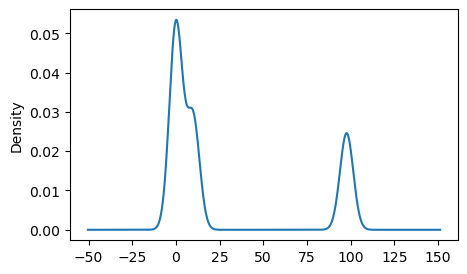

In [8]:
df.inverter_efficiency.plot.kde(figsize=(5,3))
plt.show()

In the graph you can see that there are two differentiated groups and one of them is clearly inefficient.

Rearrange the columns of the dataframe to facilitate analysis.

In [9]:
df.head()

plant      inverter_id           kw_dc           kw_ac  \
date_time                                                           
2020-05-15    p1  1BY6WEcLGh8j5v7            0.00            0.00   
2020-05-15    p1  1IF53ai7Xc0U56Y            0.00            0.00   
2020-05-15    p1  3PZuoBAID5Wc2HD            0.00            0.00   
2020-05-15    p1  7JYdWkrLSPkdwr4            0.00            0.00   
2020-05-15    p1  McdE0feGgRqW7Ca            0.00            0.00   

                    kw_day        kw_total        sensor_id  \
date_time                                                     
2020-05-15            0.00      6259559.00  HmiyD2TTLFNqkNe   
2020-05-15            0.00      6183645.00  HmiyD2TTLFNqkNe   
2020-05-15            0.00      6987759.00  HmiyD2TTLFNqkNe   
2020-05-15            0.00      7602960.00  HmiyD2TTLFNqkNe   
2020-05-15            0.00      7158964.00  HmiyD2TTLFNqkNe   

            ambient_temperature  module_temperature     irradiation  month  \
date_time                                                                    
2020-05-15                25.18               22.86            0.00      5   
2020-05-15                25.18               22.86            0.00      5   
2020-05-15                25.18               22.86            0.00      5   
2020-05-15                25.18               22.86            0.00      5   
2020-05-15                25.18               22.86            0.00      5   

            day  hour  minute  inverter_efficiency  
date_time                                           
2020-05-15   15     0       0                 0.00  
2020-05-15   15     0       0                 0.00  
2020-05-15   15     0       0                 0.00  
2020-05-15   15     0       0                 0.00  
2020-05-15   15     0       0                 0.00

In [10]:
sort_columns = [
    'plant',
    'month',
    'day',
    'hour',
    'minute',
    'sensor_id',
    'irradiation',
    'ambient_temperature',
    'module_temperature',
    'inverter_id',
    'kw_dc',
    'kw_ac',
    'inverter_efficiency',
    'kw_day',
    'kw_total',
]
df = df[sort_columns]
df

plant  month  day  hour  minute        sensor_id  \
date_time                                                              
2020-05-15 00:00:00    p1      5   15     0       0  HmiyD2TTLFNqkNe   
2020-05-15 00:00:00    p1      5   15     0       0  HmiyD2TTLFNqkNe   
2020-05-15 00:00:00    p1      5   15     0       0  HmiyD2TTLFNqkNe   
2020-05-15 00:00:00    p1      5   15     0       0  HmiyD2TTLFNqkNe   
2020-05-15 00:00:00    p1      5   15     0       0  HmiyD2TTLFNqkNe   
...                   ...    ...  ...   ...     ...              ...   
2020-06-17 23:45:00    p2      6   17    23      45  iq8k7ZNt4Mwm3w0   
2020-06-17 23:45:00    p2      6   17    23      45  iq8k7ZNt4Mwm3w0   
2020-06-17 23:45:00    p2      6   17    23      45  iq8k7ZNt4Mwm3w0   
2020-06-17 23:45:00    p2      6   17    23      45  iq8k7ZNt4Mwm3w0   
2020-06-17 23:45:00    p2      6   17    23      45  iq8k7ZNt4Mwm3w0   

                        irradiation  ambient_temperature  module_temperature  \
date_time                                                                      
2020-05-15 00:00:00            0.00                25.18               22.86   
2020-05-15 00:00:00            0.00                25.18               22.86   
2020-05-15 00:00:00            0.00                25.18               22.86   
2020-05-15 00:00:00            0.00                25.18               22.86   
2020-05-15 00:00:00            0.00                25.18               22.86   
...                             ...                  ...                 ...   
2020-06-17 23:45:00            0.00                23.20               22.54   
2020-06-17 23:45:00            0.00                23.20               22.54   
2020-06-17 23:45:00            0.00                23.20               22.54   
2020-06-17 23:45:00            0.00                23.20               22.54   
2020-06-17 23:45:00            0.00                23.20               22.54   

                         inverter_id           kw_dc           kw_ac  \
date_time                                                              
2020-05-15 00:00:00  1BY6WEcLGh8j5v7            0.00            0.00   
2020-05-15 00:00:00  1IF53ai7Xc0U56Y            0.00            0.00   
2020-05-15 00:00:00  3PZuoBAID5Wc2HD            0.00            0.00   
2020-05-15 00:00:00  7JYdWkrLSPkdwr4            0.00            0.00   
2020-05-15 00:00:00  McdE0feGgRqW7Ca            0.00            0.00   
...                              ...             ...             ...   
2020-06-17 23:45:00  q49J1IKaHRwDQnt            0.00            0.00   
2020-06-17 23:45:00  rrq4fwE8jgrTyWY            0.00            0.00   
2020-06-17 23:45:00  vOuJvMaM2sgwLmb            0.00            0.00   
2020-06-17 23:45:00  xMbIugepa2P7lBB            0.00            0.00   
2020-06-17 23:45:00  xoJJ8DcxJEcupym            0.00            0.00   

                     inverter_efficiency          kw_day        kw_total  
date_time                                                                 
2020-05-15 00:00:00                 0.00            0.00      6259559.00  
2020-05-15 00:00:00                 0.00            0.00      6183645.00  
2020-05-15 00:00:00                 0.00            0.00      6987759.00  
2020-05-15 00:00:00                 0.00            0.00      7602960.00  
2020-05-15 00:00:00                 0.00            0.00      7158964.00  
...                                  ...             ...             ...  
2020-06-17 23:45:00                 0.00         4157.00       520758.00  
2020-06-17 23:45:00                 0.00         3931.00    121131356.00  
2020-06-17 23:45:00                 0.00         4322.00      2427691.00  
2020-06-17 23:45:00                 0.00         4218.00    106896394.00  
2020-06-17 23:45:00                 0.00         4316.00    209335741.00  

[136472 rows x 15 columns]

Generate daily dataframe 

The level of analysis at which we have the data is every 15 minutes, which may be too disaggregated for certain analyses.

We are going to build a version of the dataframe aggregated at the day level.

To aggregate by plant and inverter, which are the key fields of the dataset.

In [11]:
statistics = {
    'irradiation': ['min', 'mean', 'max'],
    'ambient_temperature': ['min', 'mean', 'max'],
    'module_temperature': ['min', 'mean', 'max'],
    'kw_dc': ['min', 'mean', 'max', 'sum'],
    'kw_ac': ['min', 'mean', 'max', 'sum'],
    'inverter_efficiency': ['min', 'mean', 'max'],
    'kw_day': ['max'],
    'kw_total': ['max'],
}
df_day = df.groupby(['plant', 'inverter_id']).resample('D').agg(statistics)
df_day

irradiation                  \
                                             min            mean   
plant inverter_id     date_time                                    
p1    1BY6WEcLGh8j5v7 2020-05-15            0.00            0.20   
                      2020-05-16            0.00            0.21   
                      2020-05-17            0.00            0.24   
                      2020-05-18            0.00            0.16   
                      2020-05-19            0.00            0.19   
...                                          ...             ...   
p2    xoJJ8DcxJEcupym 2020-06-13            0.00            0.22   
                      2020-06-14            0.00            0.23   
                      2020-06-15            0.00            0.19   
                      2020-06-16            0.00            0.17   
                      2020-06-17            0.00            0.12   

                                                 ambient_temperature  \
                                             max                 min   
plant inverter_id     date_time                                        
p1    1BY6WEcLGh8j5v7 2020-05-15            0.89               22.04   
                      2020-05-16            0.81               21.50   
                      2020-05-17            1.00               21.21   
                      2020-05-18            0.97               20.96   
                      2020-05-19            0.84               22.39   
...                                          ...                 ...   
p2    xoJJ8DcxJEcupym 2020-06-13            0.93               22.20   
                      2020-06-14            0.92               23.65   
                      2020-06-15            0.83               24.00   
                      2020-06-16            0.77               23.63   
                      2020-06-17            0.58               22.55   

                                                                  \
                                            mean             max   
plant inverter_id     date_time                                    
p1    1BY6WEcLGh8j5v7 2020-05-15           27.43           34.43   
                      2020-05-16           26.78           32.52   
                      2020-05-17           26.69           35.25   
                      2020-05-18           23.85           28.37   
                      2020-05-19           25.34           30.37   
...                                          ...             ...   
p2    xoJJ8DcxJEcupym 2020-06-13           26.12           31.91   
                      2020-06-14           27.02           32.96   
                      2020-06-15           26.56           31.61   
                      2020-06-16           26.37           30.83   
                      2020-06-17           24.85           29.04   

                                 module_temperature                  \
                                                min            mean   
plant inverter_id     date_time                                       
p1    1BY6WEcLGh8j5v7 2020-05-15              20.29           32.58   
                      2020-05-16              19.59           31.86   
                      2020-05-17              20.38           32.74   
                      2020-05-18              19.48           27.81   
                      2020-05-19              20.06           29.73   
...                                             ...             ...   
p2    xoJJ8DcxJEcupym 2020-06-13              20.88           30.39   
                      2020-06-14              22.12           31.59   
                      2020-06-15              23.00           30.00   
                      2020-06-16              22.56           29.59   
                      2020-06-17              21.91           26.67   

                                                           kw_dc  \
                                             max           

Flatten columns

In [12]:
flat_columns = df_day.columns.to_flat_index()
df_day.columns = ['_'.join(column) for column in flat_columns]
df_day

irradiation_min  irradiation_mean  \
plant inverter_id     date_time                                       
p1    1BY6WEcLGh8j5v7 2020-05-15             0.00              0.20   
                      2020-05-16             0.00              0.21   
                      2020-05-17             0.00              0.24   
                      2020-05-18             0.00              0.16   
                      2020-05-19             0.00              0.19   
...                                           ...               ...   
p2    xoJJ8DcxJEcupym 2020-06-13             0.00              0.22   
                      2020-06-14             0.00              0.23   
                      2020-06-15             0.00              0.19   
                      2020-06-16             0.00              0.17   
                      2020-06-17             0.00              0.12   

                                  irradiation_max  ambient_temperature_min  \
plant inverter_id     date_time                                              
p1    1BY6WEcLGh8j5v7 2020-05-15             0.89                    22.04   
                      2020-05-16             0.81                    21.50   
                      2020-05-17             1.00                    21.21   
                      2020-05-18             0.97                    20.96   
                      2020-05-19             0.84                    22.39   
...                                           ...                      ...   
p2    xoJJ8DcxJEcupym 2020-06-13             0.93                    22.20   
                      2020-06-14             0.92                    23.65   
                      2020-06-15             0.83                    24.00   
                      2020-06-16             0.77                    23.63   
                      2020-06-17             0.58                    22.55   

                                  ambient_temperature_mean  \
plant inverter_id     date_time                              
p1    1BY6WEcLGh8j5v7 2020-05-15                     27.43   
                      2020-05-16                     26.78   
                      2020-05-17                     26.69   
                      2020-05-18                     23.85   
                      2020-05-19                     25.34   
...                                                    ...   
p2    xoJJ8DcxJEcupym 2020-06-13                     26.12   
                      2020-06-14                     27.02   
                      2020-06-15                     26.56   
                      2020-06-16                     26.37   
                      2020-06-17                     24.85   

                                  ambient_temperature_max  \
plant inverter_id     date_time                             
p1    1BY6WEcLGh8j5v7 2020-05-15                    34.43   
                      2020-05-16                    32.52   
                      2020-05-17                    35.25   
                      2020-05-18                    28.37   
                      2020-05-19                    30.37   
...                                                   ...   
p2    xoJJ8DcxJEcupym 2020-06-13                    31.91   
                      2020-06-14                    32.96   
                      2020-06-15                    31.61   
                      2020-06-16                    30.83   
                      2020-06-17                    29.04   

                                  module_temperature_min  \
plant inverter_id     date_time                            
p1    1BY6WEcLGh8j5v7 2020-05-15                   20.29   
                      2020-05-16                   19.59   
                      2020-05-17                   20.38   
                      2020-05-18                   19.48   
                      2020-05-19                   20.06   
...                                                  ...   
p2    xoJJ8Dcx

Pass plant and inverter_id to the columns and leave the date_time as the index.

In [13]:
df_day = df_day.reset_index().rename(columns={'date_time':'date'}).set_index('date')
df_day

plant      inverter_id  irradiation_min  irradiation_mean  \
date                                                                   
2020-05-15    p1  1BY6WEcLGh8j5v7             0.00              0.20   
2020-05-16    p1  1BY6WEcLGh8j5v7             0.00              0.21   
2020-05-17    p1  1BY6WEcLGh8j5v7             0.00              0.24   
2020-05-18    p1  1BY6WEcLGh8j5v7             0.00              0.16   
2020-05-19    p1  1BY6WEcLGh8j5v7             0.00              0.19   
...          ...              ...              ...               ...   
2020-06-13    p2  xoJJ8DcxJEcupym             0.00              0.22   
2020-06-14    p2  xoJJ8DcxJEcupym             0.00              0.23   
2020-06-15    p2  xoJJ8DcxJEcupym             0.00              0.19   
2020-06-16    p2  xoJJ8DcxJEcupym             0.00              0.17   
2020-06-17    p2  xoJJ8DcxJEcupym             0.00              0.12   

            irradiation_max  ambient_temperature_min  \
date                                                   
2020-05-15             0.89                    22.04   
2020-05-16             0.81                    21.50   
2020-05-17             1.00                    21.21   
2020-05-18             0.97                    20.96   
2020-05-19             0.84                    22.39   
...                     ...                      ...   
2020-06-13             0.93                    22.20   
2020-06-14             0.92                    23.65   
2020-06-15             0.83                    24.00   
2020-06-16             0.77                    23.63   
2020-06-17             0.58                    22.55   

            ambient_temperature_mean  ambient_temperature_max  \
date                                                            
2020-05-15                     27.43                    34.43   
2020-05-16                     26.78                    32.52   
2020-05-17                     26.69                    35.25   
2020-05-18                     23.85                    28.37   
2020-05-19                     25.34                    30.37   
...                              ...                      ...   
2020-06-13                     26.12                    31.91   
2020-06-14                     27.02                    32.96   
2020-06-15                     26.56                    31.61   
2020-06-16                     26.37                    30.83   
2020-06-17                     24.85                    29.04   

            module_temperature_min  module_temperature_mean  \
date                                                          
2020-05-15                   20.29                    32.58   
2020-05-16                   19.59                    31.86   
2020-05-17                   20.38                    32.74   
2020-05-18                   19.48                    27.81   
2020-05-19                   20.06                    29.73   
...                            ...                      ...   
2020-06-13                   20.88                    30.39   
2020-06-14                   22.12                    31.59   
2020-06-15                   23.00                    30.00   
2020-06-16                   22.56                    29.59   
2020-06-17                   21.91                    26.67   

            module_temperature_max       kw_dc_min      kw_dc_mean  \
date                                                                 
2020-05-15                   55.03            0.00         2530.55   
2020-05-16                   54.23            0.00         2916.25   
2020-05-17                   63.15            0.00         3000.41   
2020-05-18                   53.94            0.00         2125.32   
2020-05-19                   51.85            0.00         2497.61   
...                            ...             ...             ...   
2020-06-13                   51.01            0.00          285.87   
2020-06-14                   52.99            0.0

### Update datamart

In [14]:
df.to_pickle('data/df_ba.pickle')
df_day.to_pickle('data/df_day.pickle')

### Read data

In [15]:
#Graphics format
sns.set_style('darkgrid')
df = pd.read_pickle('data/df_ba.pickle')
df.head()

plant  month  day  hour  minute        sensor_id     irradiation  \
date_time                                                                     
2020-05-15    p1      5   15     0       0  HmiyD2TTLFNqkNe            0.00   
2020-05-15    p1      5   15     0       0  HmiyD2TTLFNqkNe            0.00   
2020-05-15    p1      5   15     0       0  HmiyD2TTLFNqkNe            0.00   
2020-05-15    p1      5   15     0       0  HmiyD2TTLFNqkNe            0.00   
2020-05-15    p1      5   15     0       0  HmiyD2TTLFNqkNe            0.00   

            ambient_temperature  module_temperature      inverter_id  \
date_time                                                              
2020-05-15                25.18               22.86  1BY6WEcLGh8j5v7   
2020-05-15                25.18               22.86  1IF53ai7Xc0U56Y   
2020-05-15                25.18               22.86  3PZuoBAID5Wc2HD   
2020-05-15                25.18               22.86  7JYdWkrLSPkdwr4   
2020-05-15                25.18               22.86  McdE0feGgRqW7Ca   

                     kw_dc           kw_ac  inverter_efficiency  \
date_time                                                         
2020-05-15            0.00            0.00                 0.00   
2020-05-15            0.00            0.00                 0.00   
2020-05-15            0.00            0.00                 0.00   
2020-05-15            0.00            0.00                 0.00   
2020-05-15            0.00            0.00                 0.00   

                    kw_day        kw_total  
date_time                                   
2020-05-15            0.00      6259559.00  
2020-05-15            0.00      6183645.00  
2020-05-15            0.00      6987759.00  
2020-05-15            0.00      7602960.00  
2020-05-15            0.00      7158964.00

In [16]:
df_day = pd.read_pickle('data/df_day.pickle')
df.head()

plant  month  day  hour  minute        sensor_id     irradiation  \
date_time                                                                     
2020-05-15    p1      5   15     0       0  HmiyD2TTLFNqkNe            0.00   
2020-05-15    p1      5   15     0       0  HmiyD2TTLFNqkNe            0.00   
2020-05-15    p1      5   15     0       0  HmiyD2TTLFNqkNe            0.00   
2020-05-15    p1      5   15     0       0  HmiyD2TTLFNqkNe            0.00   
2020-05-15    p1      5   15     0       0  HmiyD2TTLFNqkNe            0.00   

            ambient_temperature  module_temperature      inverter_id  \
date_time                                                              
2020-05-15                25.18               22.86  1BY6WEcLGh8j5v7   
2020-05-15                25.18               22.86  1IF53ai7Xc0U56Y   
2020-05-15                25.18               22.86  3PZuoBAID5Wc2HD   
2020-05-15                25.18               22.86  7JYdWkrLSPkdwr4   
2020-05-15                25.18               22.86  McdE0feGgRqW7Ca   

                     kw_dc           kw_ac  inverter_efficiency  \
date_time                                                         
2020-05-15            0.00            0.00                 0.00   
2020-05-15            0.00            0.00                 0.00   
2020-05-15            0.00            0.00                 0.00   
2020-05-15            0.00            0.00                 0.00   
2020-05-15            0.00            0.00                 0.00   

                    kw_day        kw_total  
date_time                                   
2020-05-15            0.00      6259559.00  
2020-05-15            0.00      6183645.00  
2020-05-15            0.00      6987759.00  
2020-05-15            0.00      7602960.00  
2020-05-15            0.00      7158964.00

### Analysis and insights

The first lever is the reception of solar energy.

We have 3 kpis with which to measure this lever: incoming irradiation, ambient temperature and module temperature.

These kpis are measured with a single sensor per plant, so the data is the same for all inverters.

Generate a dataset with only one inverter from each plant to work on.

In [17]:
df

plant  month  day  hour  minute        sensor_id  \
date_time                                                              
2020-05-15 00:00:00    p1      5   15     0       0  HmiyD2TTLFNqkNe   
2020-05-15 00:00:00    p1      5   15     0       0  HmiyD2TTLFNqkNe   
2020-05-15 00:00:00    p1      5   15     0       0  HmiyD2TTLFNqkNe   
2020-05-15 00:00:00    p1      5   15     0       0  HmiyD2TTLFNqkNe   
2020-05-15 00:00:00    p1      5   15     0       0  HmiyD2TTLFNqkNe   
...                   ...    ...  ...   ...     ...              ...   
2020-06-17 23:45:00    p2      6   17    23      45  iq8k7ZNt4Mwm3w0   
2020-06-17 23:45:00    p2      6   17    23      45  iq8k7ZNt4Mwm3w0   
2020-06-17 23:45:00    p2      6   17    23      45  iq8k7ZNt4Mwm3w0   
2020-06-17 23:45:00    p2      6   17    23      45  iq8k7ZNt4Mwm3w0   
2020-06-17 23:45:00    p2      6   17    23      45  iq8k7ZNt4Mwm3w0   

                        irradiation  ambient_temperature  module_temperature  \
date_time                                                                      
2020-05-15 00:00:00            0.00                25.18               22.86   
2020-05-15 00:00:00            0.00                25.18               22.86   
2020-05-15 00:00:00            0.00                25.18               22.86   
2020-05-15 00:00:00            0.00                25.18               22.86   
2020-05-15 00:00:00            0.00                25.18               22.86   
...                             ...                  ...                 ...   
2020-06-17 23:45:00            0.00                23.20               22.54   
2020-06-17 23:45:00            0.00                23.20               22.54   
2020-06-17 23:45:00            0.00                23.20               22.54   
2020-06-17 23:45:00            0.00                23.20               22.54   
2020-06-17 23:45:00            0.00                23.20               22.54   

                         inverter_id           kw_dc           kw_ac  \
date_time                                                              
2020-05-15 00:00:00  1BY6WEcLGh8j5v7            0.00            0.00   
2020-05-15 00:00:00  1IF53ai7Xc0U56Y            0.00            0.00   
2020-05-15 00:00:00  3PZuoBAID5Wc2HD            0.00            0.00   
2020-05-15 00:00:00  7JYdWkrLSPkdwr4            0.00            0.00   
2020-05-15 00:00:00  McdE0feGgRqW7Ca            0.00            0.00   
...                              ...             ...             ...   
2020-06-17 23:45:00  q49J1IKaHRwDQnt            0.00            0.00   
2020-06-17 23:45:00  rrq4fwE8jgrTyWY            0.00            0.00   
2020-06-17 23:45:00  vOuJvMaM2sgwLmb            0.00            0.00   
2020-06-17 23:45:00  xMbIugepa2P7lBB            0.00            0.00   
2020-06-17 23:45:00  xoJJ8DcxJEcupym            0.00            0.00   

                     inverter_efficiency          kw_day        kw_total  
date_time                                                                 
2020-05-15 00:00:00                 0.00            0.00      6259559.00  
2020-05-15 00:00:00                 0.00            0.00      6183645.00  
2020-05-15 00:00:00                 0.00            0.00      6987759.00  
2020-05-15 00:00:00                 0.00            0.00      7602960.00  
2020-05-15 00:00:00                 0.00            0.00      7158964.00  
...                                  ...             ...             ...  
2020-06-17 23:45:00                 0.00         4157.00       520758.00  
2020-06-17 23:45:00                 0.00         3931.00    121131356.00  
2020-06-17 23:45:00                 0.00         4322.00      2427691.00  
2020-06-17 23:45:00                 0.00         4218.00    106896394.00  
2020-06-17 23:45:00                 0.00         4316.00    209335741.00  

[136472 rows x 15 columns]

In [18]:
reception = df.loc[(df.inverter_id == '1BY6WEcLGh8j5v7') | (df.inverter_id == 'q49J1IKaHRwDQnt'),
       'plant':'module_temperature']
reception

plant  month  day  hour  minute        sensor_id  \
date_time                                                              
2020-05-15 00:00:00    p1      5   15     0       0  HmiyD2TTLFNqkNe   
2020-05-15 00:15:00    p1      5   15     0      15  HmiyD2TTLFNqkNe   
2020-05-15 00:30:00    p1      5   15     0      30  HmiyD2TTLFNqkNe   
2020-05-15 00:45:00    p1      5   15     0      45  HmiyD2TTLFNqkNe   
2020-05-15 01:00:00    p1      5   15     1       0  HmiyD2TTLFNqkNe   
...                   ...    ...  ...   ...     ...              ...   
2020-06-17 22:45:00    p2      6   17    22      45  iq8k7ZNt4Mwm3w0   
2020-06-17 23:00:00    p2      6   17    23       0  iq8k7ZNt4Mwm3w0   
2020-06-17 23:15:00    p2      6   17    23      15  iq8k7ZNt4Mwm3w0   
2020-06-17 23:30:00    p2      6   17    23      30  iq8k7ZNt4Mwm3w0   
2020-06-17 23:45:00    p2      6   17    23      45  iq8k7ZNt4Mwm3w0   

                        irradiation  ambient_temperature  module_temperature  
date_time                                                                     
2020-05-15 00:00:00            0.00                25.18               22.86  
2020-05-15 00:15:00            0.00                25.08               22.76  
2020-05-15 00:30:00            0.00                24.94               22.59  
2020-05-15 00:45:00            0.00                24.85               22.36  
2020-05-15 01:00:00            0.00                24.62               22.17  
...                             ...                  ...                 ...  
2020-06-17 22:45:00            0.00                23.51               22.86  
2020-06-17 23:00:00            0.00                23.48               22.74  
2020-06-17 23:15:00            0.00                23.35               22.49  
2020-06-17 23:30:00            0.00                23.29               22.37  
2020-06-17 23:45:00            0.00                23.20               22.54  

[6413 rows x 9 columns]

#### Do the two plants receive the same amount of solar energy?

In [19]:
temp = reception.groupby('plant').agg(
    {
        'irradiation':'sum',
        'ambient_temperature':'mean',
        'module_temperature':'mean'
    }
)
temp

irradiation  ambient_temperature  module_temperature
plant                                                         
p1             726.40                25.56               31.18
p2             758.49                28.07               32.77

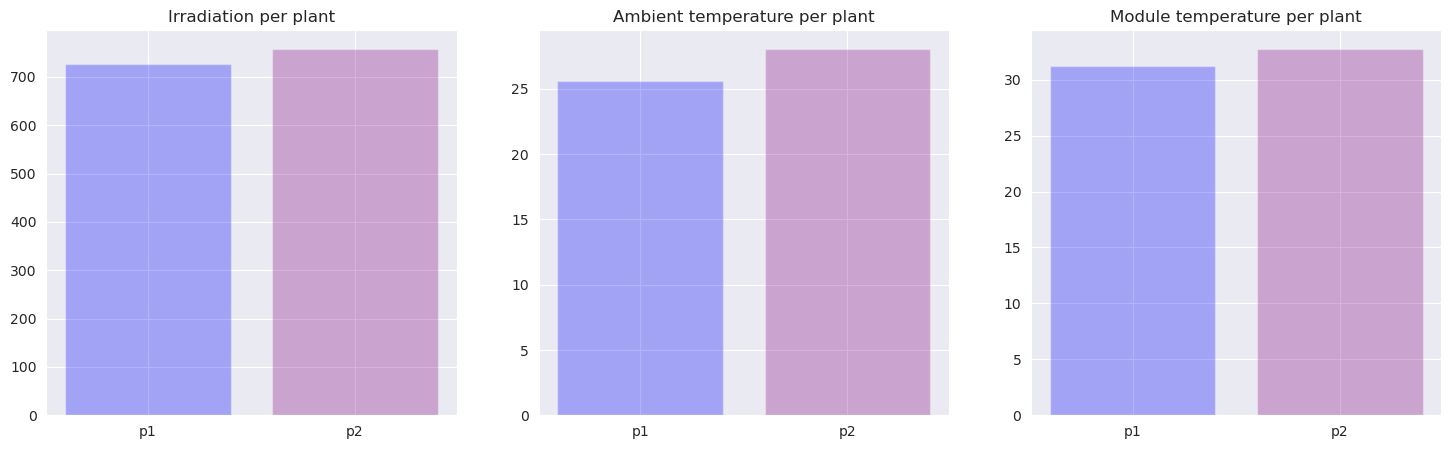

In [20]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
ax[0].bar(temp.index, temp.irradiation, color=['blue', 'purple'], alpha=0.3)
ax[1].bar(temp.index, temp.ambient_temperature, color=['blue', 'purple'], alpha=0.3)
ax[2].bar(temp.index, temp.module_temperature, color=['blue', 'purple'], alpha=0.3)
ax[0].set_title('Irradiation per plant')
ax[1].set_title('Ambient temperature per plant')
ax[2].set_title('Module temperature per plant')
plt.show()

Conclusions:

* In general, plant 2 receives more solar energy than plant 1.
* But this difference cannot imply the performance problem that supposedly exists

#### How are these three variables related?

In [21]:
temp = reception[['plant', 'irradiation', 'ambient_temperature', 'module_temperature']]
temp

plant     irradiation  ambient_temperature  \
date_time                                                        
2020-05-15 00:00:00    p1            0.00                25.18   
2020-05-15 00:15:00    p1            0.00                25.08   
2020-05-15 00:30:00    p1            0.00                24.94   
2020-05-15 00:45:00    p1            0.00                24.85   
2020-05-15 01:00:00    p1            0.00                24.62   
...                   ...             ...                  ...   
2020-06-17 22:45:00    p2            0.00                23.51   
2020-06-17 23:00:00    p2            0.00                23.48   
2020-06-17 23:15:00    p2            0.00                23.35   
2020-06-17 23:30:00    p2            0.00                23.29   
2020-06-17 23:45:00    p2            0.00                23.20   

                     module_temperature  
date_time                                
2020-05-15 00:00:00               22.86  
2020-05-15 00:15:00               22.76  
2020-05-15 00:30:00               22.59  
2020-05-15 00:45:00               22.36  
2020-05-15 01:00:00               22.17  
...                                 ...  
2020-06-17 22:45:00               22.86  
2020-06-17 23:00:00               22.74  
2020-06-17 23:15:00               22.49  
2020-06-17 23:30:00               22.37  
2020-06-17 23:45:00               22.54  

[6413 rows x 4 columns]

In [22]:
corr_temp = temp[['irradiation', 'ambient_temperature', 'module_temperature']].corr()
corr_temp

irradiation  ambient_temperature  module_temperature
irradiation                    1.00                 0.65                0.95
ambient_temperature            0.65                 1.00                0.82
module_temperature             0.95                 0.82                1.00

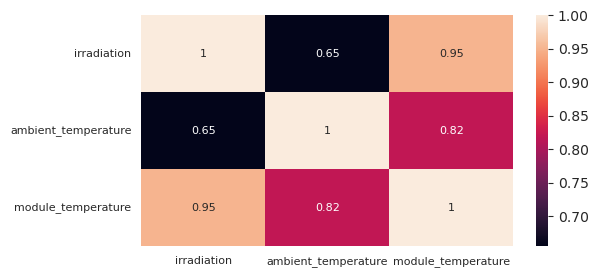

In [23]:
plt.figure(figsize=(6,3))
f = sns.heatmap(corr_temp, annot=True, annot_kws={"fontsize": 8})
f.tick_params(axis='both', labelsize=8, rotation=360)
plt.show()

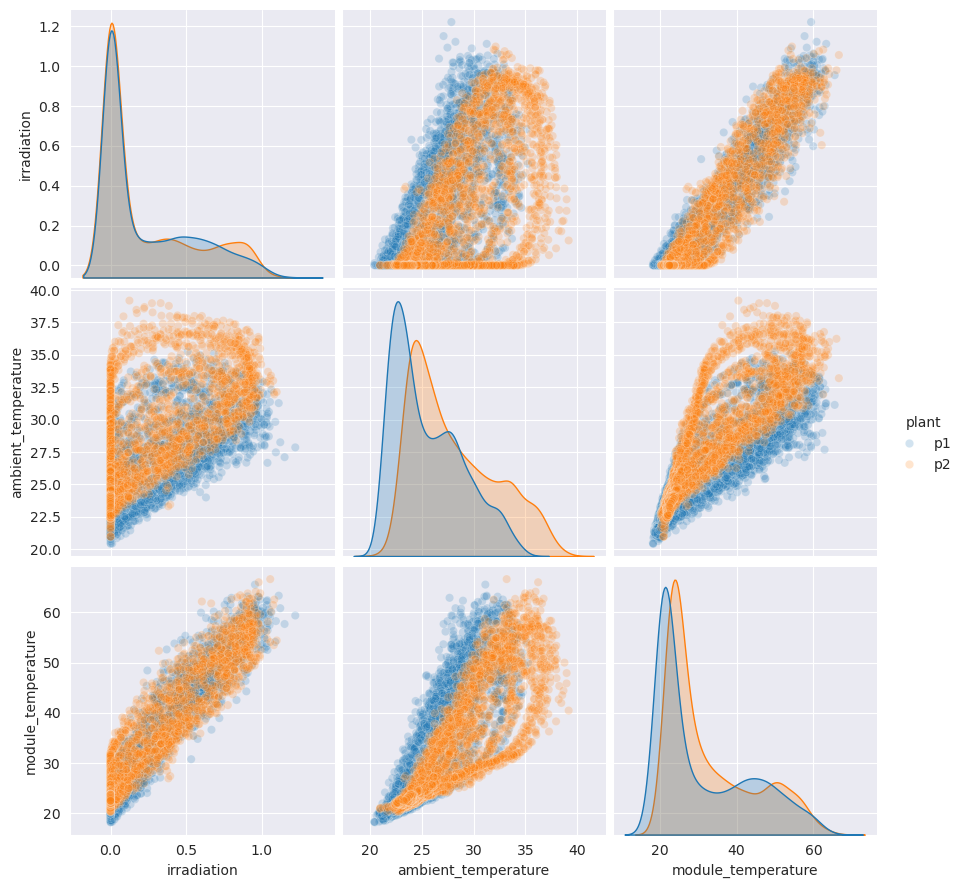

In [24]:
sns.pairplot(data=temp, hue='plant', height=3, plot_kws={'alpha':0.2})
plt.show()

Conclusions:

* Irradiation correlates highly with module temperature
* But not so much with room temperature
* Therefore, a first way to identify defective or dirty modules is to locate those that produce little energy when the irradiation is high.

#### How is irradiation and temperature distributed throughout the day?

In [25]:
temp = pd.crosstab(index=reception.hour, columns=reception.plant,
            values=reception.irradiation, aggfunc='mean')
temp

plant              p1              p2
hour                                 
0                0.00            0.00
1                0.00            0.00
2                0.00            0.00
3                0.00            0.00
4                0.00            0.00
5                0.00            0.00
6                0.04            0.04
7                0.19            0.19
8                0.37            0.39
9                0.53            0.57
10               0.64            0.69
11               0.73            0.76
12               0.74            0.79
13               0.69            0.69
14               0.58            0.60
15               0.46            0.44
16               0.29            0.28
17               0.13            0.12
18               0.02            0.02
19               0.00            0.00
20               0.00            0.00
21               0.00            0.00
22               0.00            0.00
23               0.00            0.00

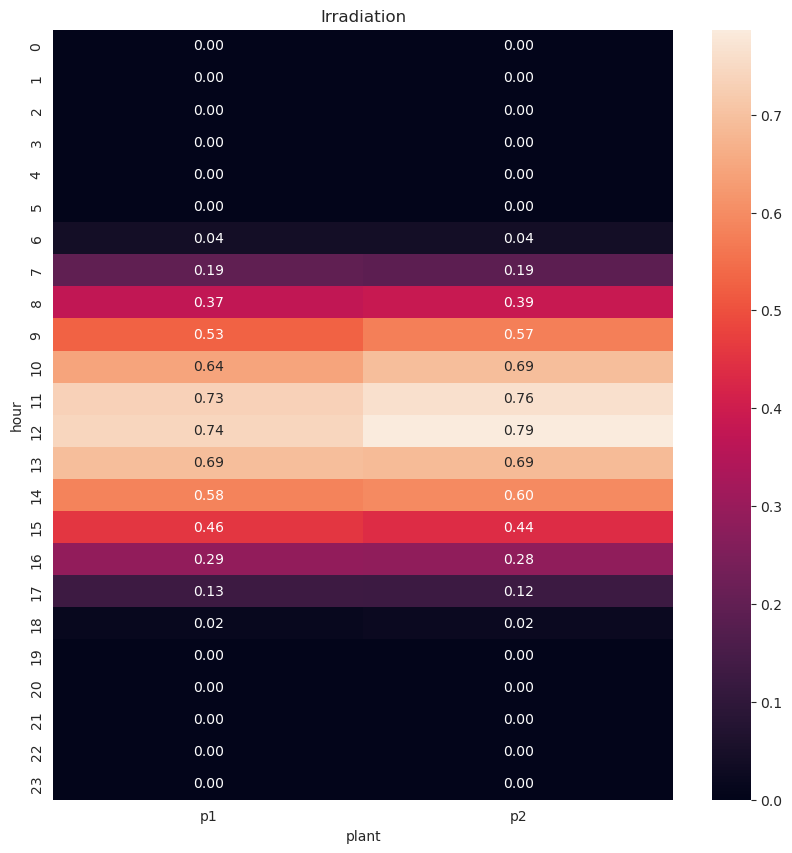

In [26]:
plt.figure(figsize=(10,10))
sns.heatmap(temp, annot=True, fmt='.2f').set(title="Irradiation")
plt.show()

In [27]:
temp = pd.crosstab(index=reception.hour, columns=reception.plant,
            values=reception.ambient_temperature, aggfunc='mean')
temp

plant              p1              p2
hour                                 
0               22.80           25.20
1               22.63           24.82
2               22.46           24.48
3               22.32           24.27
4               22.17           24.07
5               22.06           23.91
6               22.20           24.19
7               23.34           25.48
8               24.92           27.05
9               26.48           28.61
10              27.65           30.17
11              28.80           31.43
12              29.62           32.55
13              30.10           33.01
14              30.29           33.16
15              29.99           32.81
16              29.38           32.44
17              28.29           31.59
18              26.66           30.00
19              25.36           28.61
20              24.50           27.63
21              23.87           26.75
22              23.26           26.06
23              22.92           25.46

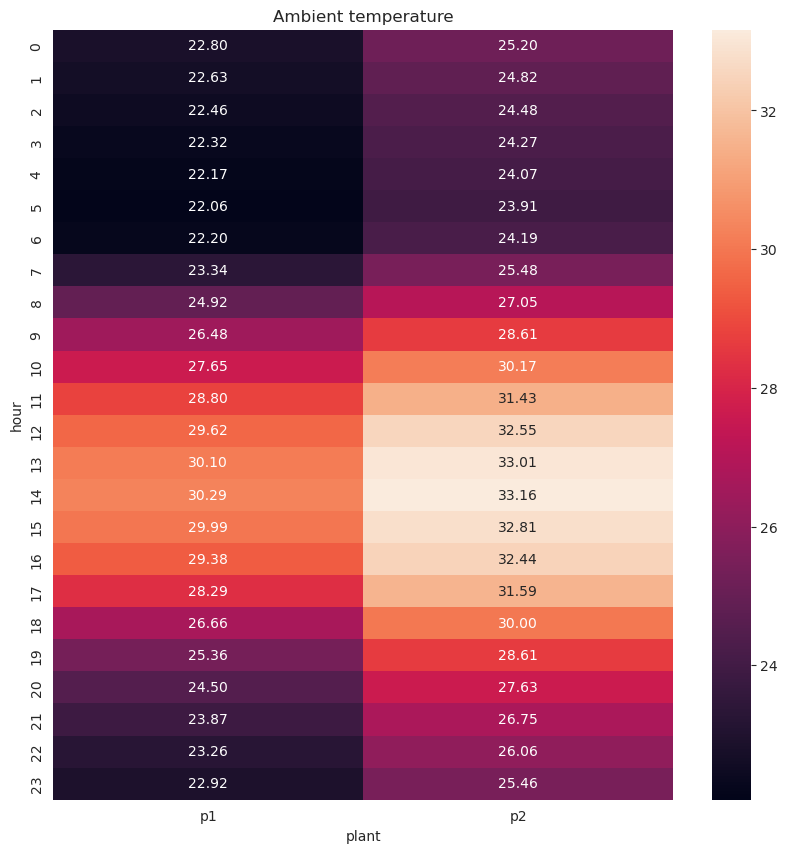

In [28]:
plt.figure(figsize=(10,10))
sns.heatmap(temp, annot=True, fmt='.2f').set(title="Ambient temperature")
plt.show()

Conclusions:

* Both plants have similar patterns. We could think that they are in geographical areas not very far away.
* There is irradiation (and therefore a priori the plants should produce) between 7 and 17
* Maximum irradiation occurs between 11 and 12
* The maximum ambient temperature occurs between 2 and 6 p.m.

#### Are both plants equally capable of generating DC from irradiation?

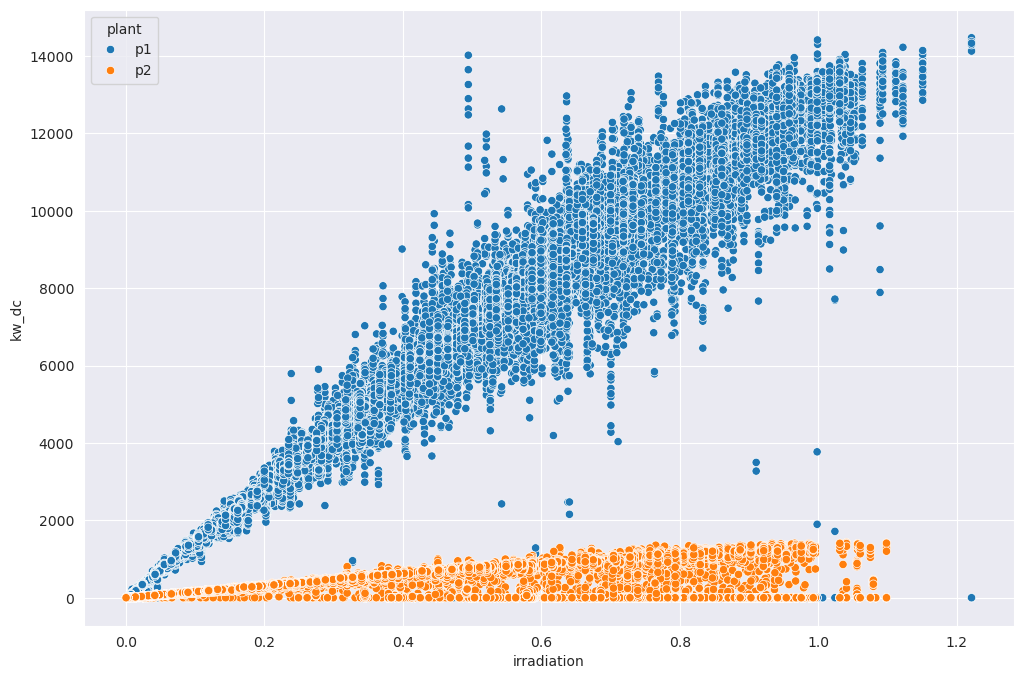

In [29]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=df, x='irradiation', y='kw_dc', hue='plant')
plt.show()

* Plant number 2 produces much less kW at the same irradiation levels.

* During the exploratory data analysis we had seen that the relationship between dc and ac on plant 1 was disproportionate compared to the data on plant 2.

* And also that the dc and ac data did not match those of kw_day.

Analyze the relationship between the variables irradiation and kw_day

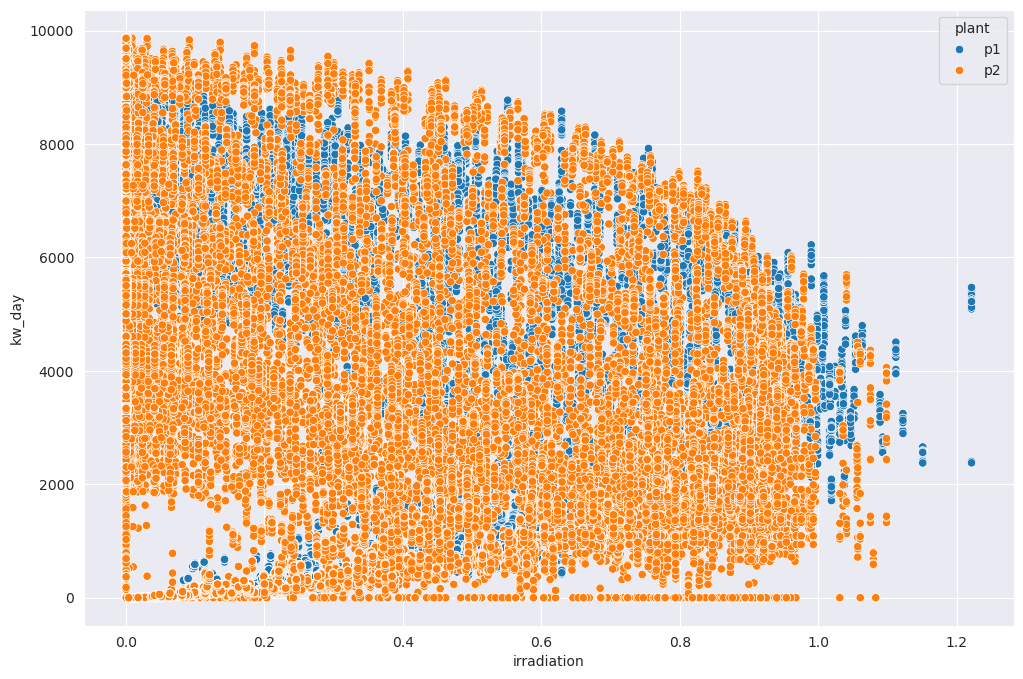

In [30]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=df, x='irradiation', y='kw_day', hue='plant')
plt.show()

* Apparently the relationship is that the more irradiation, the less kw generated. Which doesn't make sense.

* It even seems that the kw maximums occur in hours of zero irradiation.

* The kw_day variable is an ACCUMULATED. That means that it should reach its maximum when the last hour of the day arrives, for example 23:45, where obviously the irradiation is zero.
* And not having data until after 7 o'clock, which is when we see that there is irradiation.

Analyze the average value of the kw_day variable per hour.

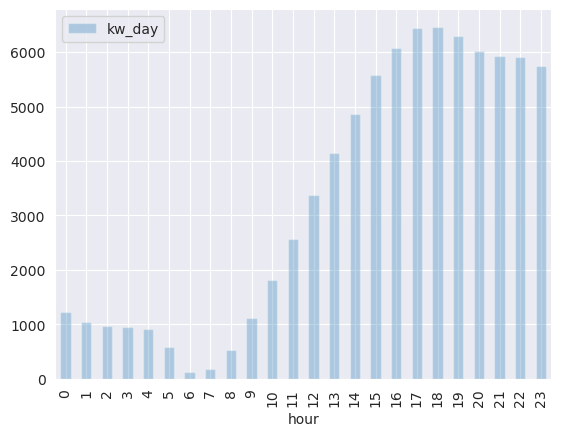

In [31]:
df.groupby('hour')[['kw_day']].mean().plot.bar(alpha=0.3)
plt.show()

There is generation between 0 and 6 a.m.

And also after 6 p.m. it begins to decline, which should not happen if it is accumulated.

Conclusion:

Cumulative variables such as kw_day and kw_total are not consistent.

But the truth is that we don't trust the others much either.

**It will be necessary to consult with the administrator of the data sources to resolve inconsistencies in the information.**

But in order to continue we are going to assume that the dc and ac data are correct.

And under that assumption we will obtain our conclusions.

**INSIGHT #1: Plant 2 generates much lower levels of DC even at similar irradiation levels**

#### Is energy generation constant throughout the days?

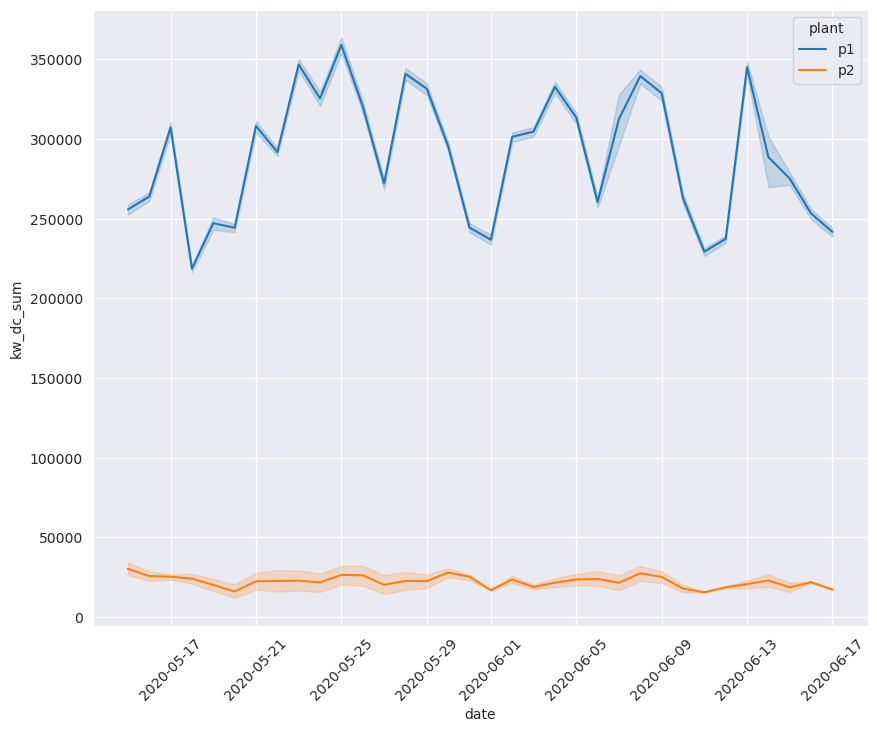

In [32]:
plt.figure(figsize=(10,8))
f = sns.lineplot(data=df_day, x=df_day.index, y='kw_dc_sum', hue='plant')
plt.xticks(rotation=45)
plt.show()

In the graph you can see that plant 1 has much more variability while plant 2 is much more constant.

But above all we are surprised by the low levels of DC generation on plant 2 compared to plant 1.

Examine the energy generation in each day

In [33]:
df['date'] = df.index.date
df.head()

plant  month  day  hour  minute        sensor_id     irradiation  \
date_time                                                                     
2020-05-15    p1      5   15     0       0  HmiyD2TTLFNqkNe            0.00   
2020-05-15    p1      5   15     0       0  HmiyD2TTLFNqkNe            0.00   
2020-05-15    p1      5   15     0       0  HmiyD2TTLFNqkNe            0.00   
2020-05-15    p1      5   15     0       0  HmiyD2TTLFNqkNe            0.00   
2020-05-15    p1      5   15     0       0  HmiyD2TTLFNqkNe            0.00   

            ambient_temperature  module_temperature      inverter_id  \
date_time                                                              
2020-05-15                25.18               22.86  1BY6WEcLGh8j5v7   
2020-05-15                25.18               22.86  1IF53ai7Xc0U56Y   
2020-05-15                25.18               22.86  3PZuoBAID5Wc2HD   
2020-05-15                25.18               22.86  7JYdWkrLSPkdwr4   
2020-05-15                25.18               22.86  McdE0feGgRqW7Ca   

                     kw_dc           kw_ac  inverter_efficiency  \
date_time                                                         
2020-05-15            0.00            0.00                 0.00   
2020-05-15            0.00            0.00                 0.00   
2020-05-15            0.00            0.00                 0.00   
2020-05-15            0.00            0.00                 0.00   
2020-05-15            0.00            0.00                 0.00   

                    kw_day        kw_total        date  
date_time                                               
2020-05-15            0.00      6259559.00  2020-05-15  
2020-05-15            0.00      6183645.00  2020-05-15  
2020-05-15            0.00      6987759.00  2020-05-15  
2020-05-15            0.00      7602960.00  2020-05-15  
2020-05-15            0.00      7158964.00  2020-05-15

Generate a temporary dataframe to analyze the generation of hourly DC on each day on plant 1.

In [34]:
dc_constant_p1 = df[df.plant == 'p1'].groupby(['plant', 'date', 'hour'])['kw_dc'].sum()
dc_constant_p1

plant  date        hour
p1     2020-05-15  0                 0.00
                   1                 0.00
                   2                 0.00
                   3                 0.00
                   4                 0.00
                                ...      
       2020-06-17  19                0.00
                   20                0.00
                   21                0.00
                   22                0.00
                   23                0.00
Name: kw_dc, Length: 796, dtype: float64

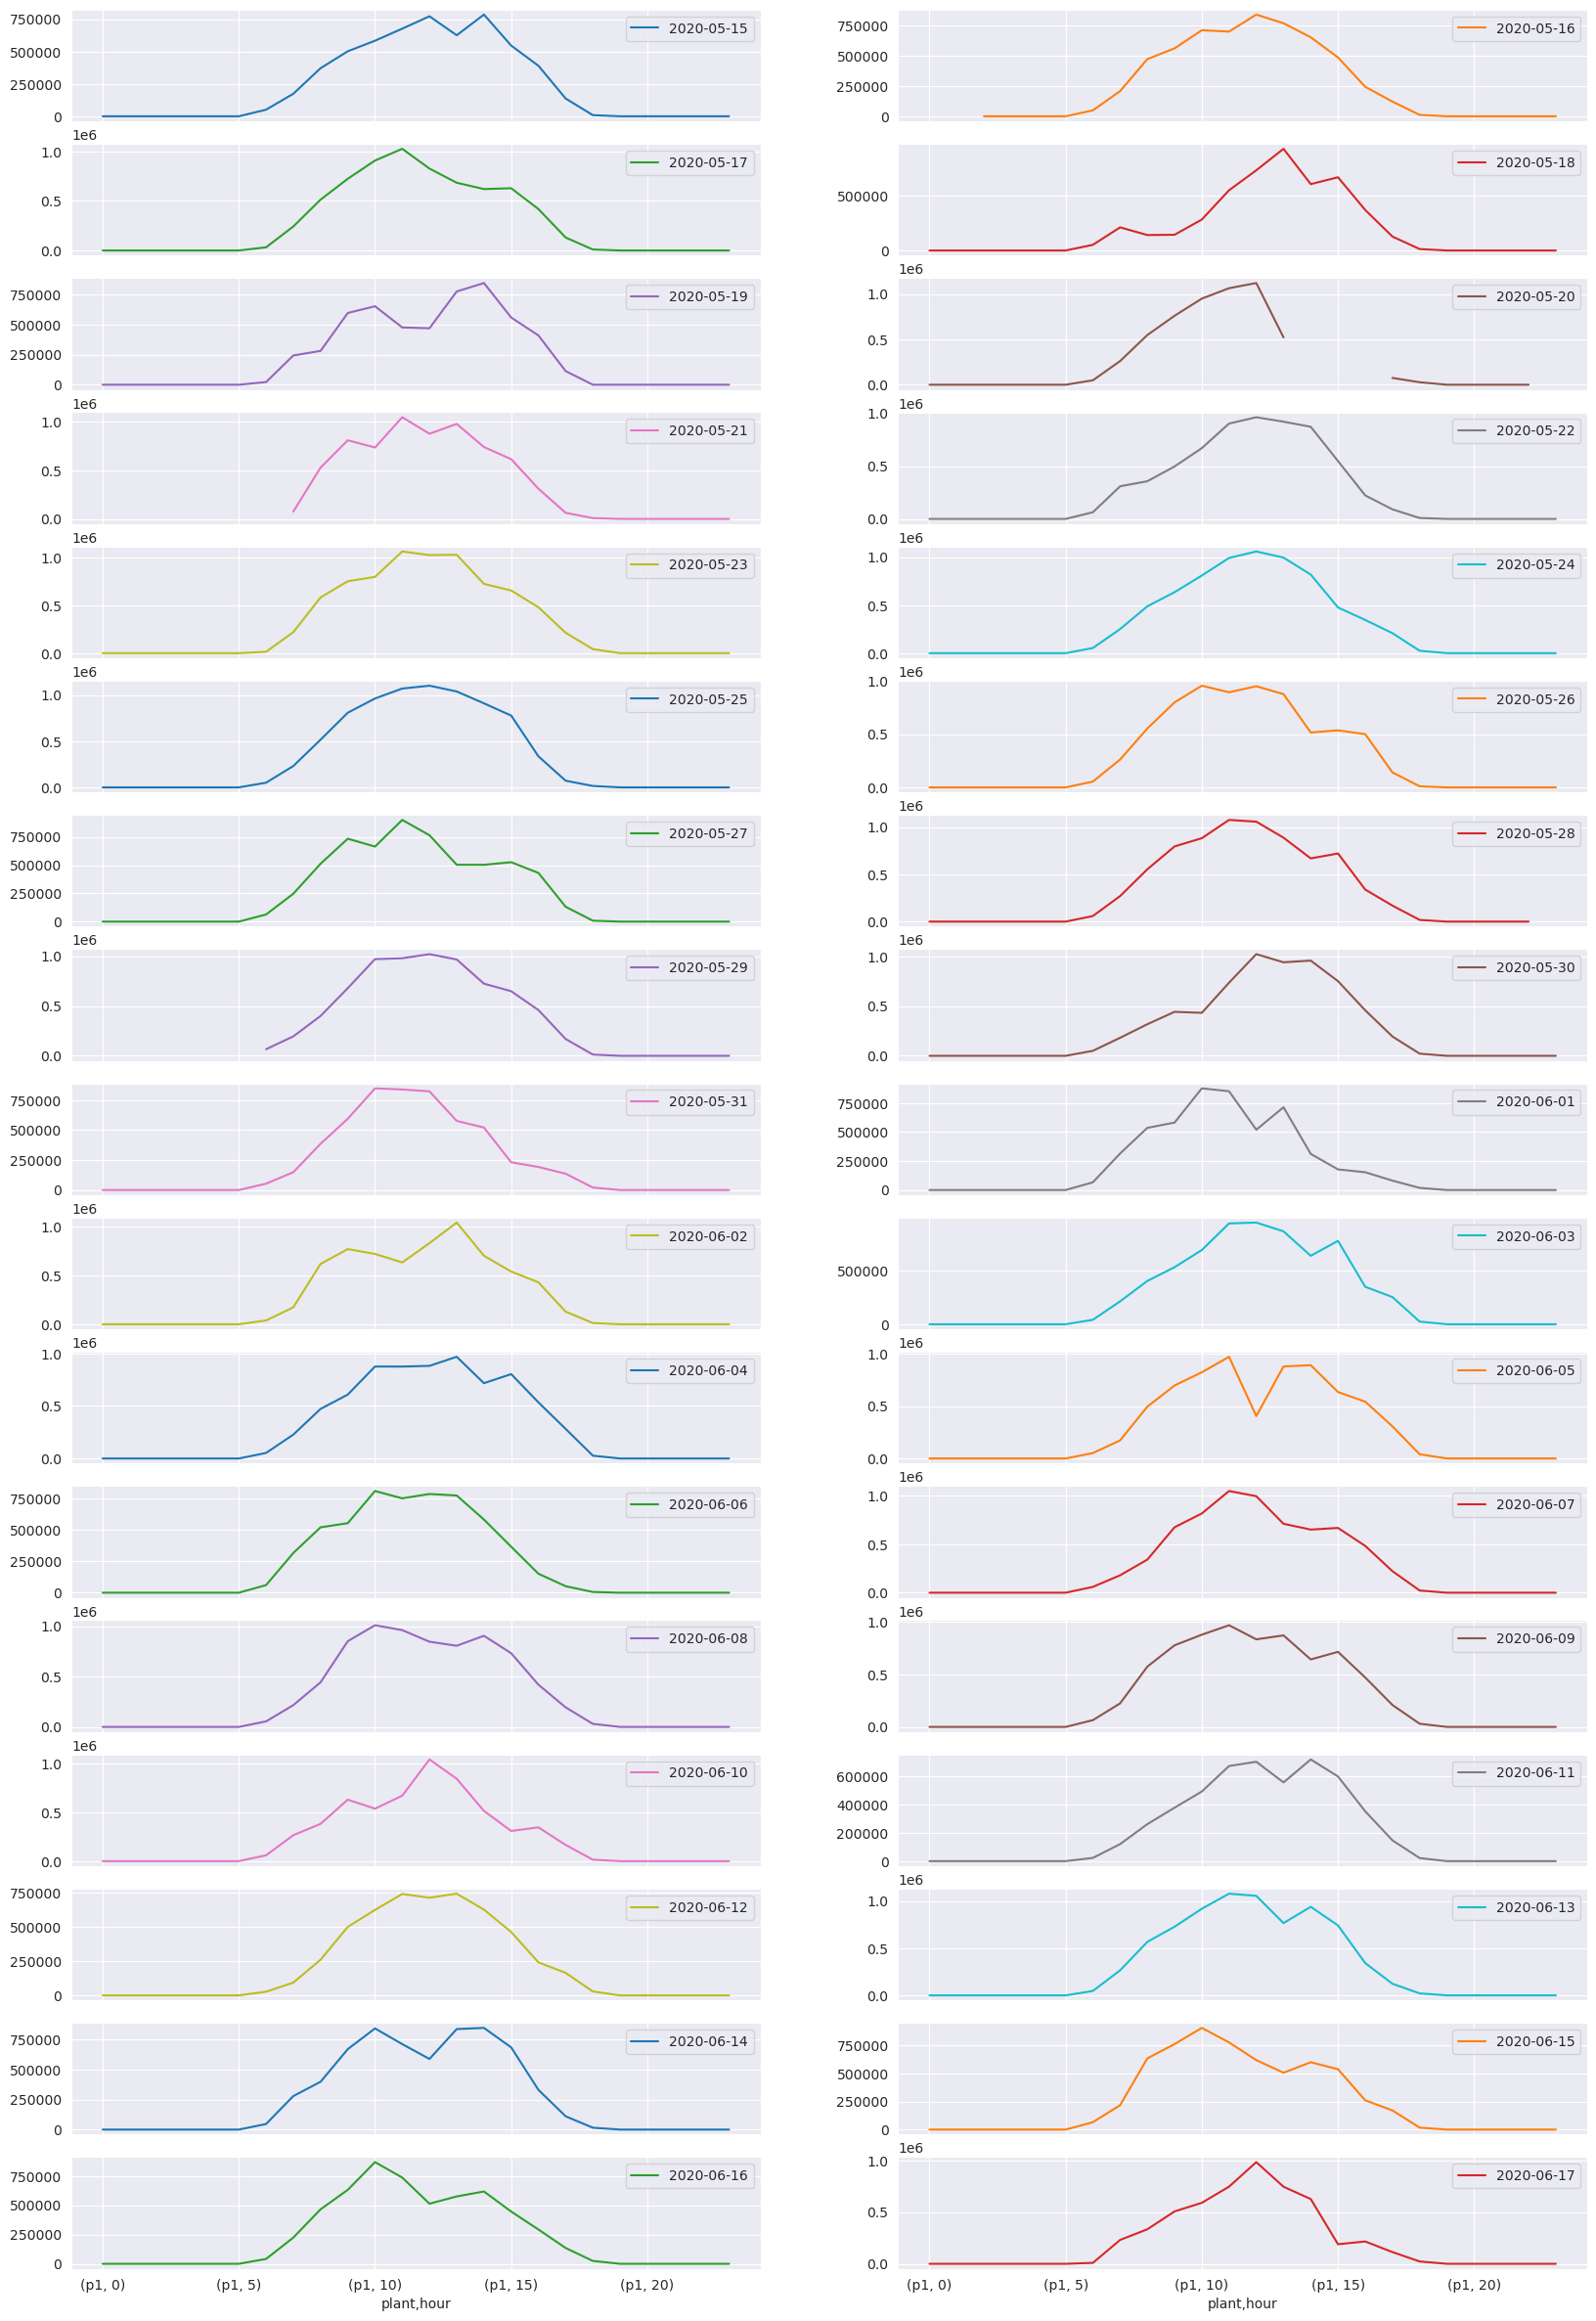

In [35]:
dc_constant_p1.unstack(level=1).plot(subplots=True, layout=(17,2), sharex=True,
                                     figsize=(20,30))
plt.show()

Conclusions:

* On plant 1, similar patterns are maintained every day
* Except for a break on May 20th and a strange crash on June 5th
* But none seem to be structural
* Therefore, although each day could have different production totals, the intraday patterns are similar and seem correct


Repeat the analysis on plant 2

In [36]:
dc_constant_p2 = df[df.plant == 'p2'].groupby(['plant', 'date', 'hour']).kw_dc.sum()
dc_constant_p2

plant  date        hour
p2     2020-05-15  0                 0.00
                   1                 0.00
                   2                 0.00
                   3                 0.00
                   4                 0.00
                                ...      
       2020-06-17  19                0.00
                   20                0.00
                   21                0.00
                   22                0.00
                   23                0.00
Name: kw_dc, Length: 816, dtype: float64

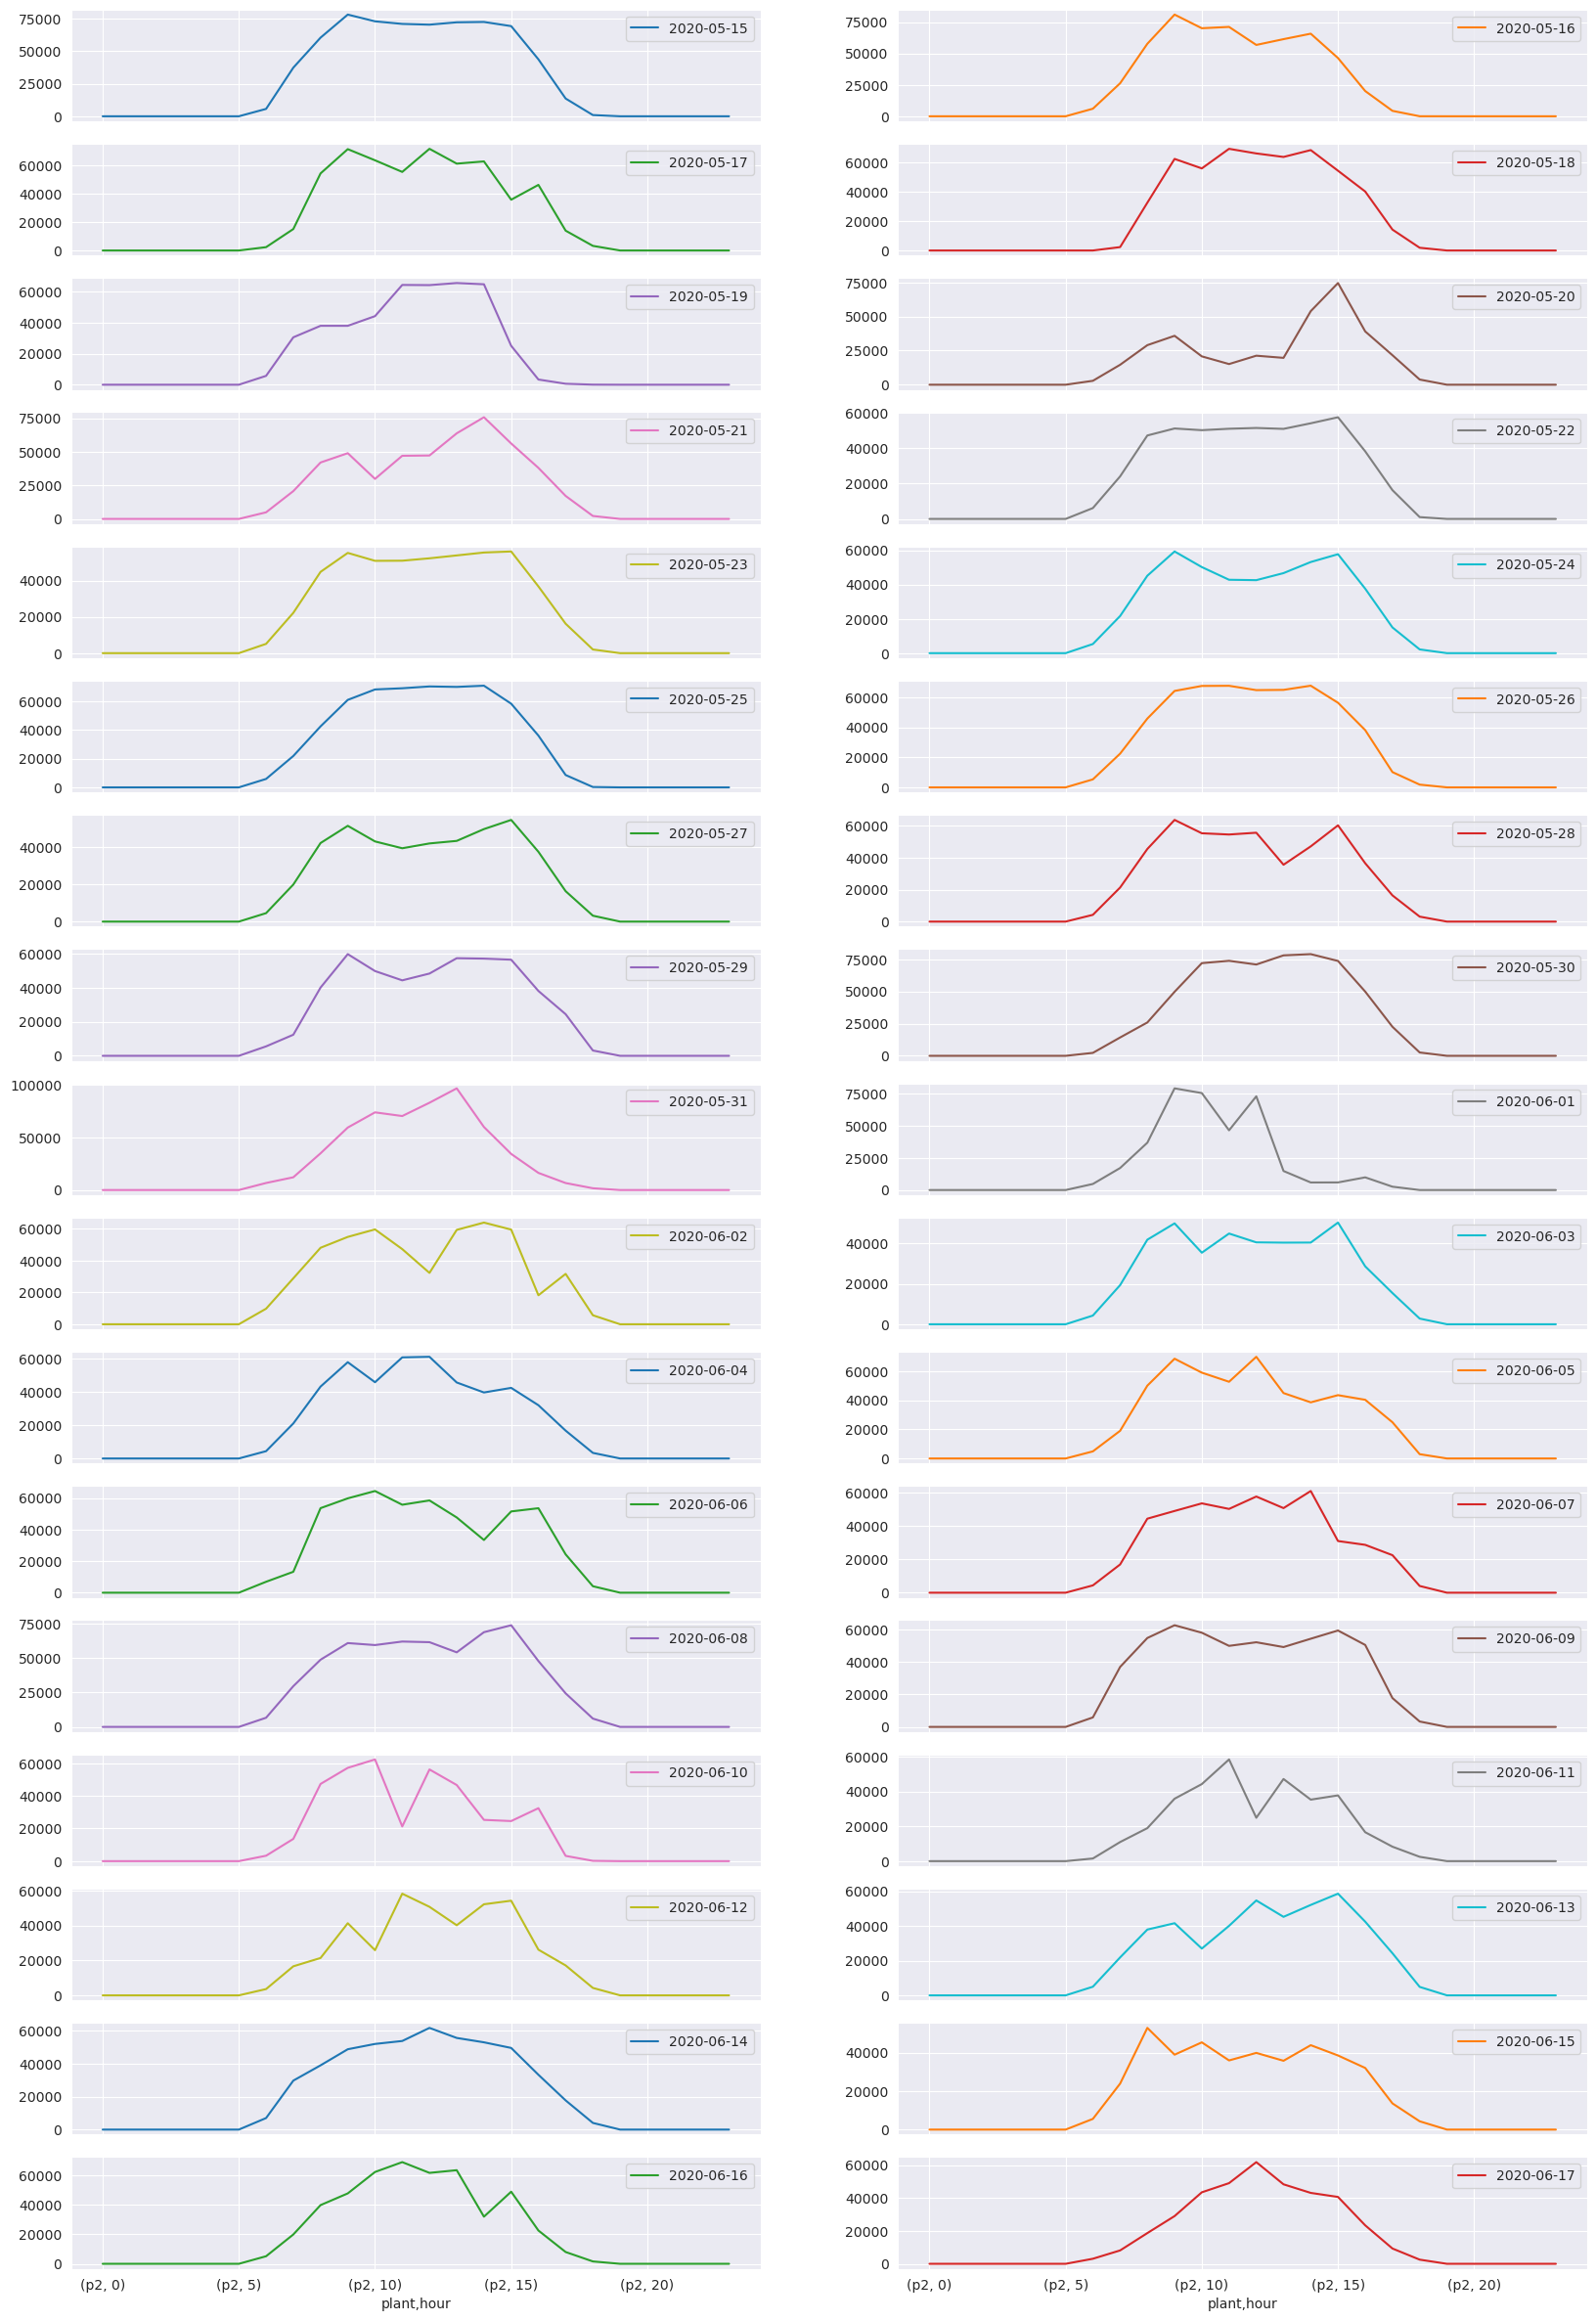

In [37]:
dc_constant_p2.unstack(level=1).plot(subplots=True, layout=(17,2),
                                     sharex=True, figsize=(20,30))
plt.show()

Conclusions:

* Again, May 20 shows us a drop in energy production
* Production levels are constant during the days, but always about 10 times below the levels of plant 1

**INSIGHT #2: The lower levels of plant 2 are constant and present daily curves that seem normal.**

#### Is the DC to AC conversion generated correctly?

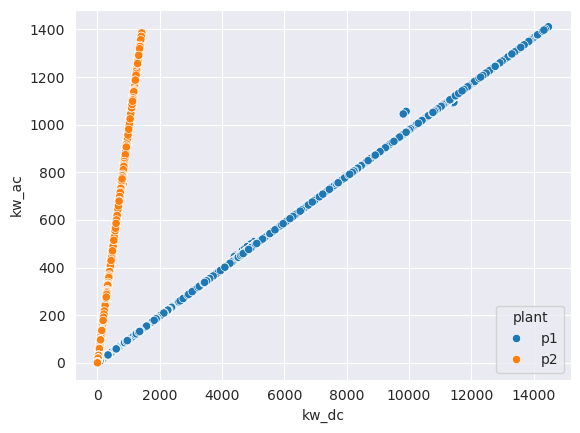

In [38]:
sns.scatterplot(data=df, x='kw_dc', y='kw_ac', hue='plant')
plt.show()

Plant 2 transforms the current much more efficiently.

Analyze the inverter efficiency variable

In [39]:
temp = df.groupby(['plant', 'hour'], as_index=False)['inverter_efficiency'].mean()
temp.sample(12)

plant  hour  inverter_efficiency
5     p1     5                 0.00
20    p1    20                 0.00
14    p1    14                 9.76
9     p1     9                 9.78
27    p2     3                 0.00
29    p2     5                 0.58
45    p2    21                 0.00
13    p1    13                 9.68
21    p1    21                 0.00
18    p1    18                 6.53
10    p1    10                 9.77
40    p2    16                95.85

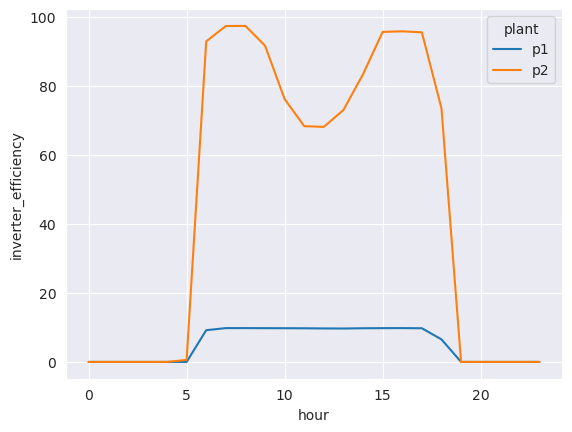

In [40]:
sns.lineplot(data=temp, x='hour', y='inverter_efficiency', hue='plant')
plt.show()

**INSIGHT #3: Plant 1 has a very low capacity to transform DC to AC, which suggests problems with the inverters.**

Points to consider:

1. Analyze the energy transformation at the inverter level of plant 1, to determine if the low capacity occurs in all of them or there are some that bias the average.

2. Review why plant 2 loses efficiency during the hours of highest irradiation


Let's start with the second, comparing the production of DC with that of AC in plant 2.

In [41]:
temp = df[['plant', 'hour', 'kw_dc', 'kw_ac']].melt(id_vars=['plant', 'hour'])
temp

plant  hour variable           value
0         p1     0    kw_dc            0.00
1         p1     0    kw_dc            0.00
2         p1     0    kw_dc            0.00
3         p1     0    kw_dc            0.00
4         p1     0    kw_dc            0.00
...      ...   ...      ...             ...
272939    p2    23    kw_ac            0.00
272940    p2    23    kw_ac            0.00
272941    p2    23    kw_ac            0.00
272942    p2    23    kw_ac            0.00
272943    p2    23    kw_ac            0.00

[272944 rows x 4 columns]

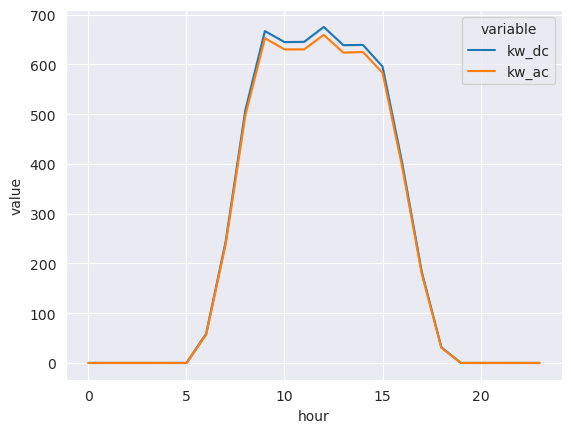

In [42]:
sns.lineplot(data=temp[temp.plant == 'p2'], x='hour', y='value',
             hue='variable', errorbar=('ci', False))
plt.show()

We see that indeed during central hours there is a loss of efficiency. But nowhere near the level of loss that we had seen in the previous analysis.

Let's analyze the distribution of efficiency in those hours.

In [43]:
temp = df[df.plant == 'p2'].between_time('08:00:00','15:00:00')
temp

plant  month  day  hour  minute        sensor_id  \
date_time                                                              
2020-05-15 08:00:00    p2      5   15     8       0  iq8k7ZNt4Mwm3w0   
2020-05-15 08:00:00    p2      5   15     8       0  iq8k7ZNt4Mwm3w0   
2020-05-15 08:00:00    p2      5   15     8       0  iq8k7ZNt4Mwm3w0   
2020-05-15 08:00:00    p2      5   15     8       0  iq8k7ZNt4Mwm3w0   
2020-05-15 08:00:00    p2      5   15     8       0  iq8k7ZNt4Mwm3w0   
...                   ...    ...  ...   ...     ...              ...   
2020-06-17 15:00:00    p2      6   17    15       0  iq8k7ZNt4Mwm3w0   
2020-06-17 15:00:00    p2      6   17    15       0  iq8k7ZNt4Mwm3w0   
2020-06-17 15:00:00    p2      6   17    15       0  iq8k7ZNt4Mwm3w0   
2020-06-17 15:00:00    p2      6   17    15       0  iq8k7ZNt4Mwm3w0   
2020-06-17 15:00:00    p2      6   17    15       0  iq8k7ZNt4Mwm3w0   

                        irradiation  ambient_temperature  module_temperature  \
date_time                                                                      
2020-05-15 08:00:00            0.46                27.68               35.71   
2020-05-15 08:00:00            0.46                27.68               35.71   
2020-05-15 08:00:00            0.46                27.68               35.71   
2020-05-15 08:00:00            0.46                27.68               35.71   
2020-05-15 08:00:00            0.46                27.68               35.71   
...                             ...                  ...                 ...   
2020-06-17 15:00:00            0.36                27.23               29.35   
2020-06-17 15:00:00            0.36                27.23               29.35   
2020-06-17 15:00:00            0.36                27.23               29.35   
2020-06-17 15:00:00            0.36                27.23               29.35   
2020-06-17 15:00:00            0.36                27.23               29.35   

                         inverter_id           kw_dc           kw_ac  \
date_time                                                              
2020-05-15 08:00:00  4UPUqMRk7TRMgml          581.05          569.41   
2020-05-15 08:00:00  81aHJ1q11NBPMrL          534.67          524.09   
2020-05-15 08:00:00  9kRcWv60rDACzjR          568.53          557.16   
2020-05-15 08:00:00  Et9kgGMDl729KT4          526.24          515.83   
2020-05-15 08:00:00  IQ2d7wF4YD8zU1Q          578.17          566.58   
...                              ...             ...             ...   
2020-06-17 15:00:00  q49J1IKaHRwDQnt          562.34          551.13   
2020-06-17 15:00:00  rrq4fwE8jgrTyWY          534.27          523.71   
2020-06-17 15:00:00  vOuJvMaM2sgwLmb          578.85          567.15   
2020-06-17 15:00:00  xMbIugepa2P7lBB          568.86          557.49   
2020-06-17 15:00:00  xoJJ8DcxJEcupym          578.49          566.90   

                     inverter_efficiency          kw_day        kw_total  \
date_time                                                                  
2020-05-15 08:00:00                98.00          554.00      2429565.00   
2020-05-15 08:00:00                98.02          516.60   1215279252.60   
2020-05-15 08:00:00                98.00          551.80   2247720128.80   
2020-05-15 08:00:00                98.02          503.00      1704753.00   
2020-05-15 08:00:00                97.99          552.79     19942078.79   
...                                  ...             ...             ...   
2020-06-17 15:00:00                98.01         3380.87       519981.87   
2020-06-17 15:00:00                98.02         3190.40    121130615.40   
2020-06-17 15:00:00                97.98         3534.07      2426903.07   
2020-06-17 15:00:00                98.00         3433.50    106895609.50   
2020-06-17 15:00:00                98.00         3534.67    209334959.67   

                           date  
date_time                        
2020-05-15 08:00:00  2020-05-15  
2020-05-15 08:

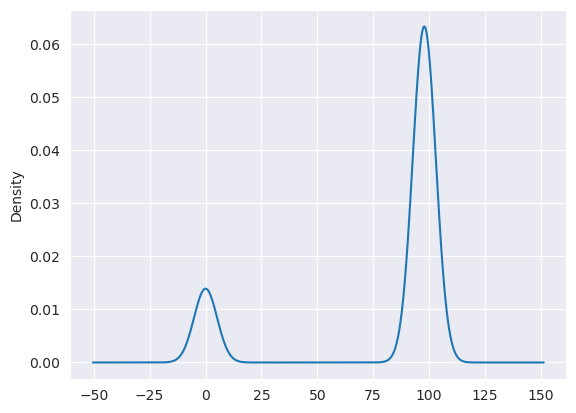

In [44]:
temp.inverter_efficiency.plot.density()
plt.show()

There is a data set with zero efficiency, and that is what causes the problem. 

But what is the cause of this zero efficiency?

Let's select those cases and review them.

In [45]:
temp[temp.kw_dc == 0]

plant  month  day  hour  minute        sensor_id  \
date_time                                                              
2020-05-15 09:45:00    p2      5   15     9      45  iq8k7ZNt4Mwm3w0   
2020-05-15 09:45:00    p2      5   15     9      45  iq8k7ZNt4Mwm3w0   
2020-05-15 09:45:00    p2      5   15     9      45  iq8k7ZNt4Mwm3w0   
2020-05-15 09:45:00    p2      5   15     9      45  iq8k7ZNt4Mwm3w0   
2020-05-15 10:00:00    p2      5   15    10       0  iq8k7ZNt4Mwm3w0   
...                   ...    ...  ...   ...     ...              ...   
2020-06-16 14:30:00    p2      6   16    14      30  iq8k7ZNt4Mwm3w0   
2020-06-16 14:30:00    p2      6   16    14      30  iq8k7ZNt4Mwm3w0   
2020-06-16 14:30:00    p2      6   16    14      30  iq8k7ZNt4Mwm3w0   
2020-06-16 14:30:00    p2      6   16    14      30  iq8k7ZNt4Mwm3w0   
2020-06-16 14:30:00    p2      6   16    14      30  iq8k7ZNt4Mwm3w0   

                        irradiation  ambient_temperature  module_temperature  \
date_time                                                                      
2020-05-15 09:45:00            0.80                31.38               45.72   
2020-05-15 09:45:00            0.80                31.38               45.72   
2020-05-15 09:45:00            0.80                31.38               45.72   
2020-05-15 09:45:00            0.80                31.38               45.72   
2020-05-15 10:00:00            0.83                31.89               46.13   
...                             ...                  ...                 ...   
2020-06-16 14:30:00            0.56                30.83               44.38   
2020-06-16 14:30:00            0.56                30.83               44.38   
2020-06-16 14:30:00            0.56                30.83               44.38   
2020-06-16 14:30:00            0.56                30.83               44.38   
2020-06-16 14:30:00            0.56                30.83               44.38   

                         inverter_id           kw_dc           kw_ac  \
date_time                                                              
2020-05-15 09:45:00  81aHJ1q11NBPMrL            0.00            0.00   
2020-05-15 09:45:00  Et9kgGMDl729KT4            0.00            0.00   
2020-05-15 09:45:00  Quc1TzYxW2pYoWX            0.00            0.00   
2020-05-15 09:45:00  xoJJ8DcxJEcupym            0.00            0.00   
2020-05-15 10:00:00  81aHJ1q11NBPMrL            0.00            0.00   
...                              ...             ...             ...   
2020-06-16 14:30:00  q49J1IKaHRwDQnt            0.00            0.00   
2020-06-16 14:30:00  rrq4fwE8jgrTyWY            0.00            0.00   
2020-06-16 14:30:00  vOuJvMaM2sgwLmb            0.00            0.00   
2020-06-16 14:30:00  xMbIugepa2P7lBB            0.00            0.00   
2020-06-16 14:30:00  xoJJ8DcxJEcupym            0.00            0.00   

                     inverter_efficiency          kw_day        kw_total  \
date_time                                                                  
2020-05-15 09:45:00                 0.00         1645.00   1215280381.00   
2020-05-15 09:45:00                 0.00         1541.00      1705791.00   
2020-05-15 09:45:00                 0.00         1324.00    329510409.00   
2020-05-15 09:45:00                 0.00         1735.00    209145328.00   
2020-05-15 10:00:00                 0.00         1645.00   1215280381.00   
...                                  ...             ...             ...   
2020-06-16 14:30:00                 0.00            0.00        34379.33   
2020-06-16 14:30:00                 0.00            0.00      8075096.33   
2020-06-16 14:30:00                 0.00            0.00       173022.79   
2020-06-16 14:30:00                 0.00            0.00      7126074.93   
2020-06-16 14:30:00                 0.00            0.00     13955359.33   

                           date  
date_time                        
2020-05-15 09:45:00  2020-05-15  
2020-05-15 09:

It seems that it is not a problem with the inverter, but rather that DC has not been generated at that time.

Check the efficiency of the inverter conditioned to DC greater than zero.

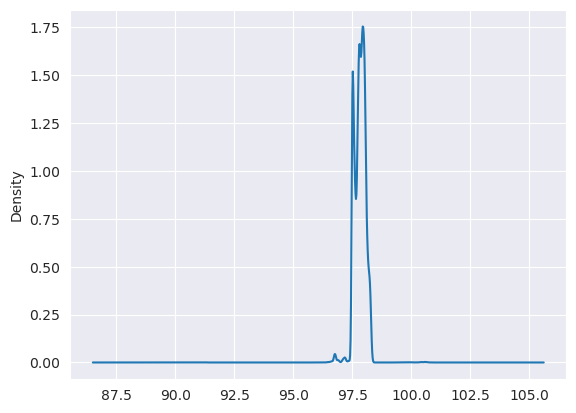

In [46]:
temp[temp.kw_dc > 0].inverter_efficiency.plot.density()
plt.show()

Indeed when there is DC the efficiency is greater than 96%.

The question then is: **Why is there no DC? Is there any pattern?**

Generate DC indicator = 0 to be able to analyze it.

In [47]:
temp['kw_dc_zero'] = np.where(temp.kw_dc == 0, 1, 0)
temp

plant  month  day  hour  minute        sensor_id  \
date_time                                                              
2020-05-15 08:00:00    p2      5   15     8       0  iq8k7ZNt4Mwm3w0   
2020-05-15 08:00:00    p2      5   15     8       0  iq8k7ZNt4Mwm3w0   
2020-05-15 08:00:00    p2      5   15     8       0  iq8k7ZNt4Mwm3w0   
2020-05-15 08:00:00    p2      5   15     8       0  iq8k7ZNt4Mwm3w0   
2020-05-15 08:00:00    p2      5   15     8       0  iq8k7ZNt4Mwm3w0   
...                   ...    ...  ...   ...     ...              ...   
2020-06-17 15:00:00    p2      6   17    15       0  iq8k7ZNt4Mwm3w0   
2020-06-17 15:00:00    p2      6   17    15       0  iq8k7ZNt4Mwm3w0   
2020-06-17 15:00:00    p2      6   17    15       0  iq8k7ZNt4Mwm3w0   
2020-06-17 15:00:00    p2      6   17    15       0  iq8k7ZNt4Mwm3w0   
2020-06-17 15:00:00    p2      6   17    15       0  iq8k7ZNt4Mwm3w0   

                        irradiation  ambient_temperature  module_temperature  \
date_time                                                                      
2020-05-15 08:00:00            0.46                27.68               35.71   
2020-05-15 08:00:00            0.46                27.68               35.71   
2020-05-15 08:00:00            0.46                27.68               35.71   
2020-05-15 08:00:00            0.46                27.68               35.71   
2020-05-15 08:00:00            0.46                27.68               35.71   
...                             ...                  ...                 ...   
2020-06-17 15:00:00            0.36                27.23               29.35   
2020-06-17 15:00:00            0.36                27.23               29.35   
2020-06-17 15:00:00            0.36                27.23               29.35   
2020-06-17 15:00:00            0.36                27.23               29.35   
2020-06-17 15:00:00            0.36                27.23               29.35   

                         inverter_id           kw_dc           kw_ac  \
date_time                                                              
2020-05-15 08:00:00  4UPUqMRk7TRMgml          581.05          569.41   
2020-05-15 08:00:00  81aHJ1q11NBPMrL          534.67          524.09   
2020-05-15 08:00:00  9kRcWv60rDACzjR          568.53          557.16   
2020-05-15 08:00:00  Et9kgGMDl729KT4          526.24          515.83   
2020-05-15 08:00:00  IQ2d7wF4YD8zU1Q          578.17          566.58   
...                              ...             ...             ...   
2020-06-17 15:00:00  q49J1IKaHRwDQnt          562.34          551.13   
2020-06-17 15:00:00  rrq4fwE8jgrTyWY          534.27          523.71   
2020-06-17 15:00:00  vOuJvMaM2sgwLmb          578.85          567.15   
2020-06-17 15:00:00  xMbIugepa2P7lBB          568.86          557.49   
2020-06-17 15:00:00  xoJJ8DcxJEcupym          578.49          566.90   

                     inverter_efficiency          kw_day        kw_total  \
date_time                                                                  
2020-05-15 08:00:00                98.00          554.00      2429565.00   
2020-05-15 08:00:00                98.02          516.60   1215279252.60   
2020-05-15 08:00:00                98.00          551.80   2247720128.80   
2020-05-15 08:00:00                98.02          503.00      1704753.00   
2020-05-15 08:00:00                97.99          552.79     19942078.79   
...                                  ...             ...             ...   
2020-06-17 15:00:00                98.01         3380.87       519981.87   
2020-06-17 15:00:00                98.02         3190.40    121130615.40   
2020-06-17 15:00:00                97.98         3534.07      2426903.07   
2020-06-17 15:00:00                98.00         3433.50    106895609.50   
2020-06-17 15:00:00                98.00         3534.67    209334959.67   

                           date  kw_dc_zero  
date_time                                    
2020-05-15 08:00:00  202

We start with the numerical variables.

In [48]:
temp.groupby('kw_dc_zero')[
    ['irradiation', 'ambient_temperature', 'module_temperature']
].mean()

irradiation  ambient_temperature  module_temperature
kw_dc_zero                                                         
0                     0.59                30.48               44.32
1                     0.80                32.48               52.03

In the ambient temperature there is not much difference, but in the temperature of the module and in the irradiation there is.

Could it be that if the module gets too hot it stops generating DC?

Let's see it by comparing the module temperature with the DC generation.

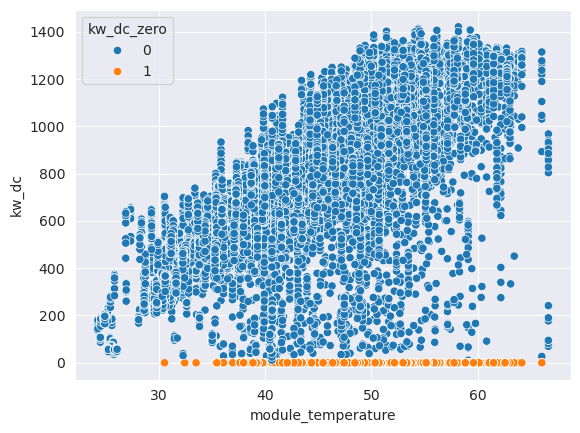

In [49]:
sns.scatterplot(data=temp, x='module_temperature', y='kw_dc', hue='kw_dc_zero')
plt.show()

The previous hypothesis is not confirmed, since there are many cases of high temperatures where DC is generated, and also of kw_dc equal to zero in almost all temperature ranges.

Let's now analyze the categorical ones, starting with the inverter.

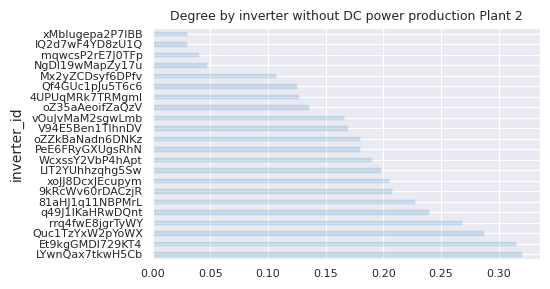

In [50]:
temp.groupby('inverter_id').kw_dc_zero.mean().sort_values(ascending=False)\
    .plot.barh(alpha=0.2, figsize=(5,3))
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.title('Degree by inverter without DC power production Plant 2', fontsize=9)
plt.show()

There is a big difference in the percentage of zero DC production per inverter.

From some that have less than 5% to some that exceed 30%.

**INSIGHT #4: On plant 2 there are several inverters to which sufficient DC production is not reaching, and therefore whose modules need revision.**

Analyze inverters from the point of view of average efficiency

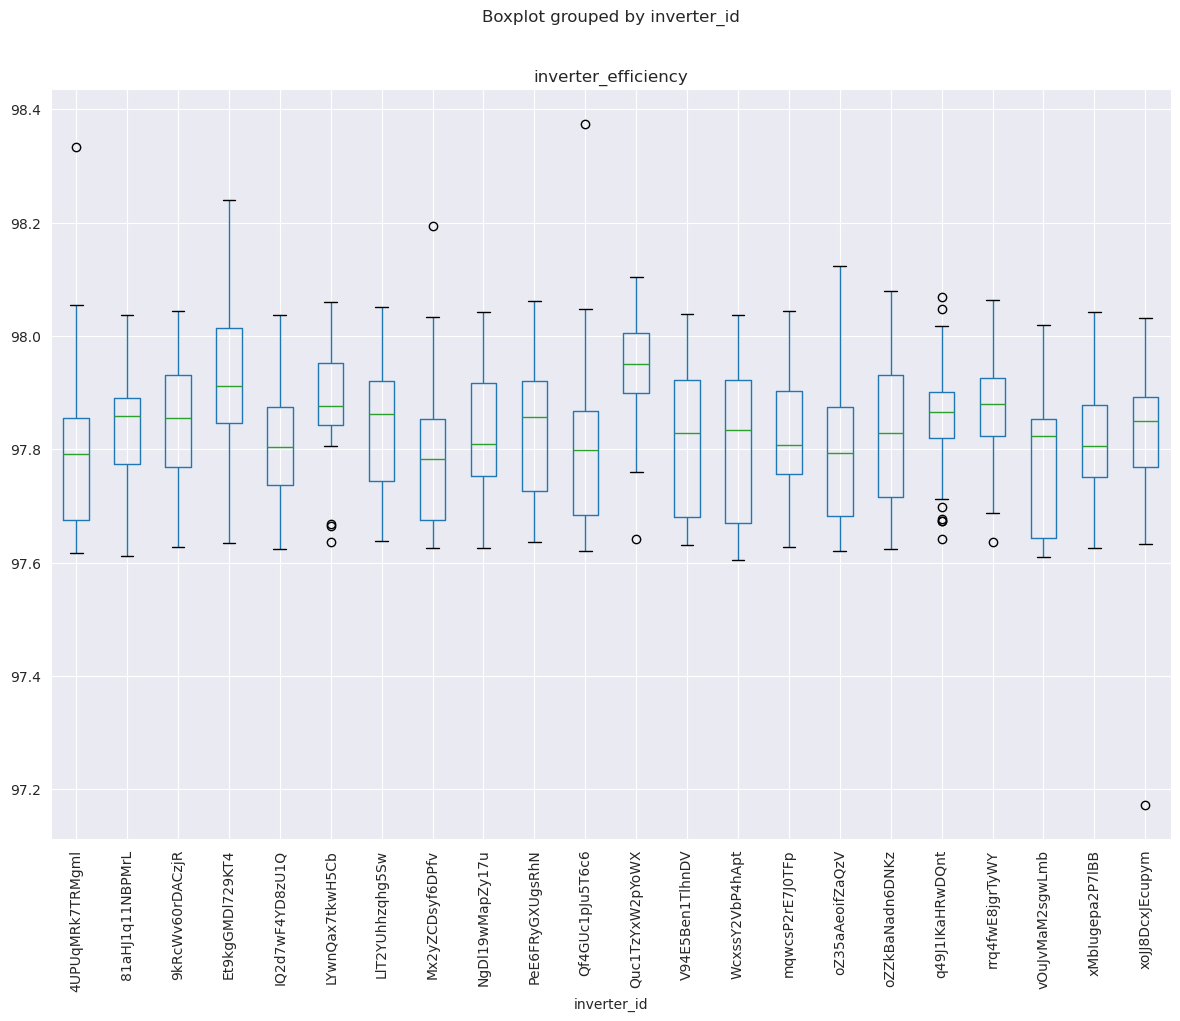

In [51]:
temp[temp.kw_dc > 0].groupby(['inverter_id','date'], as_index=False)\
    .inverter_efficiency.mean().boxplot(column='inverter_efficiency',
                                        by='inverter_id',
                                        figsize=(14,10))
plt.xticks(rotation=90)
plt.show()

**INSIGHT #5: Once we discount the problem of not generating DC, the inverters on plant 2 do work well and do the job of transforming to AC well.**

To finish analyzing the efficiency of the inverters, we can see their performance on each day to see if there may have been specific problems.

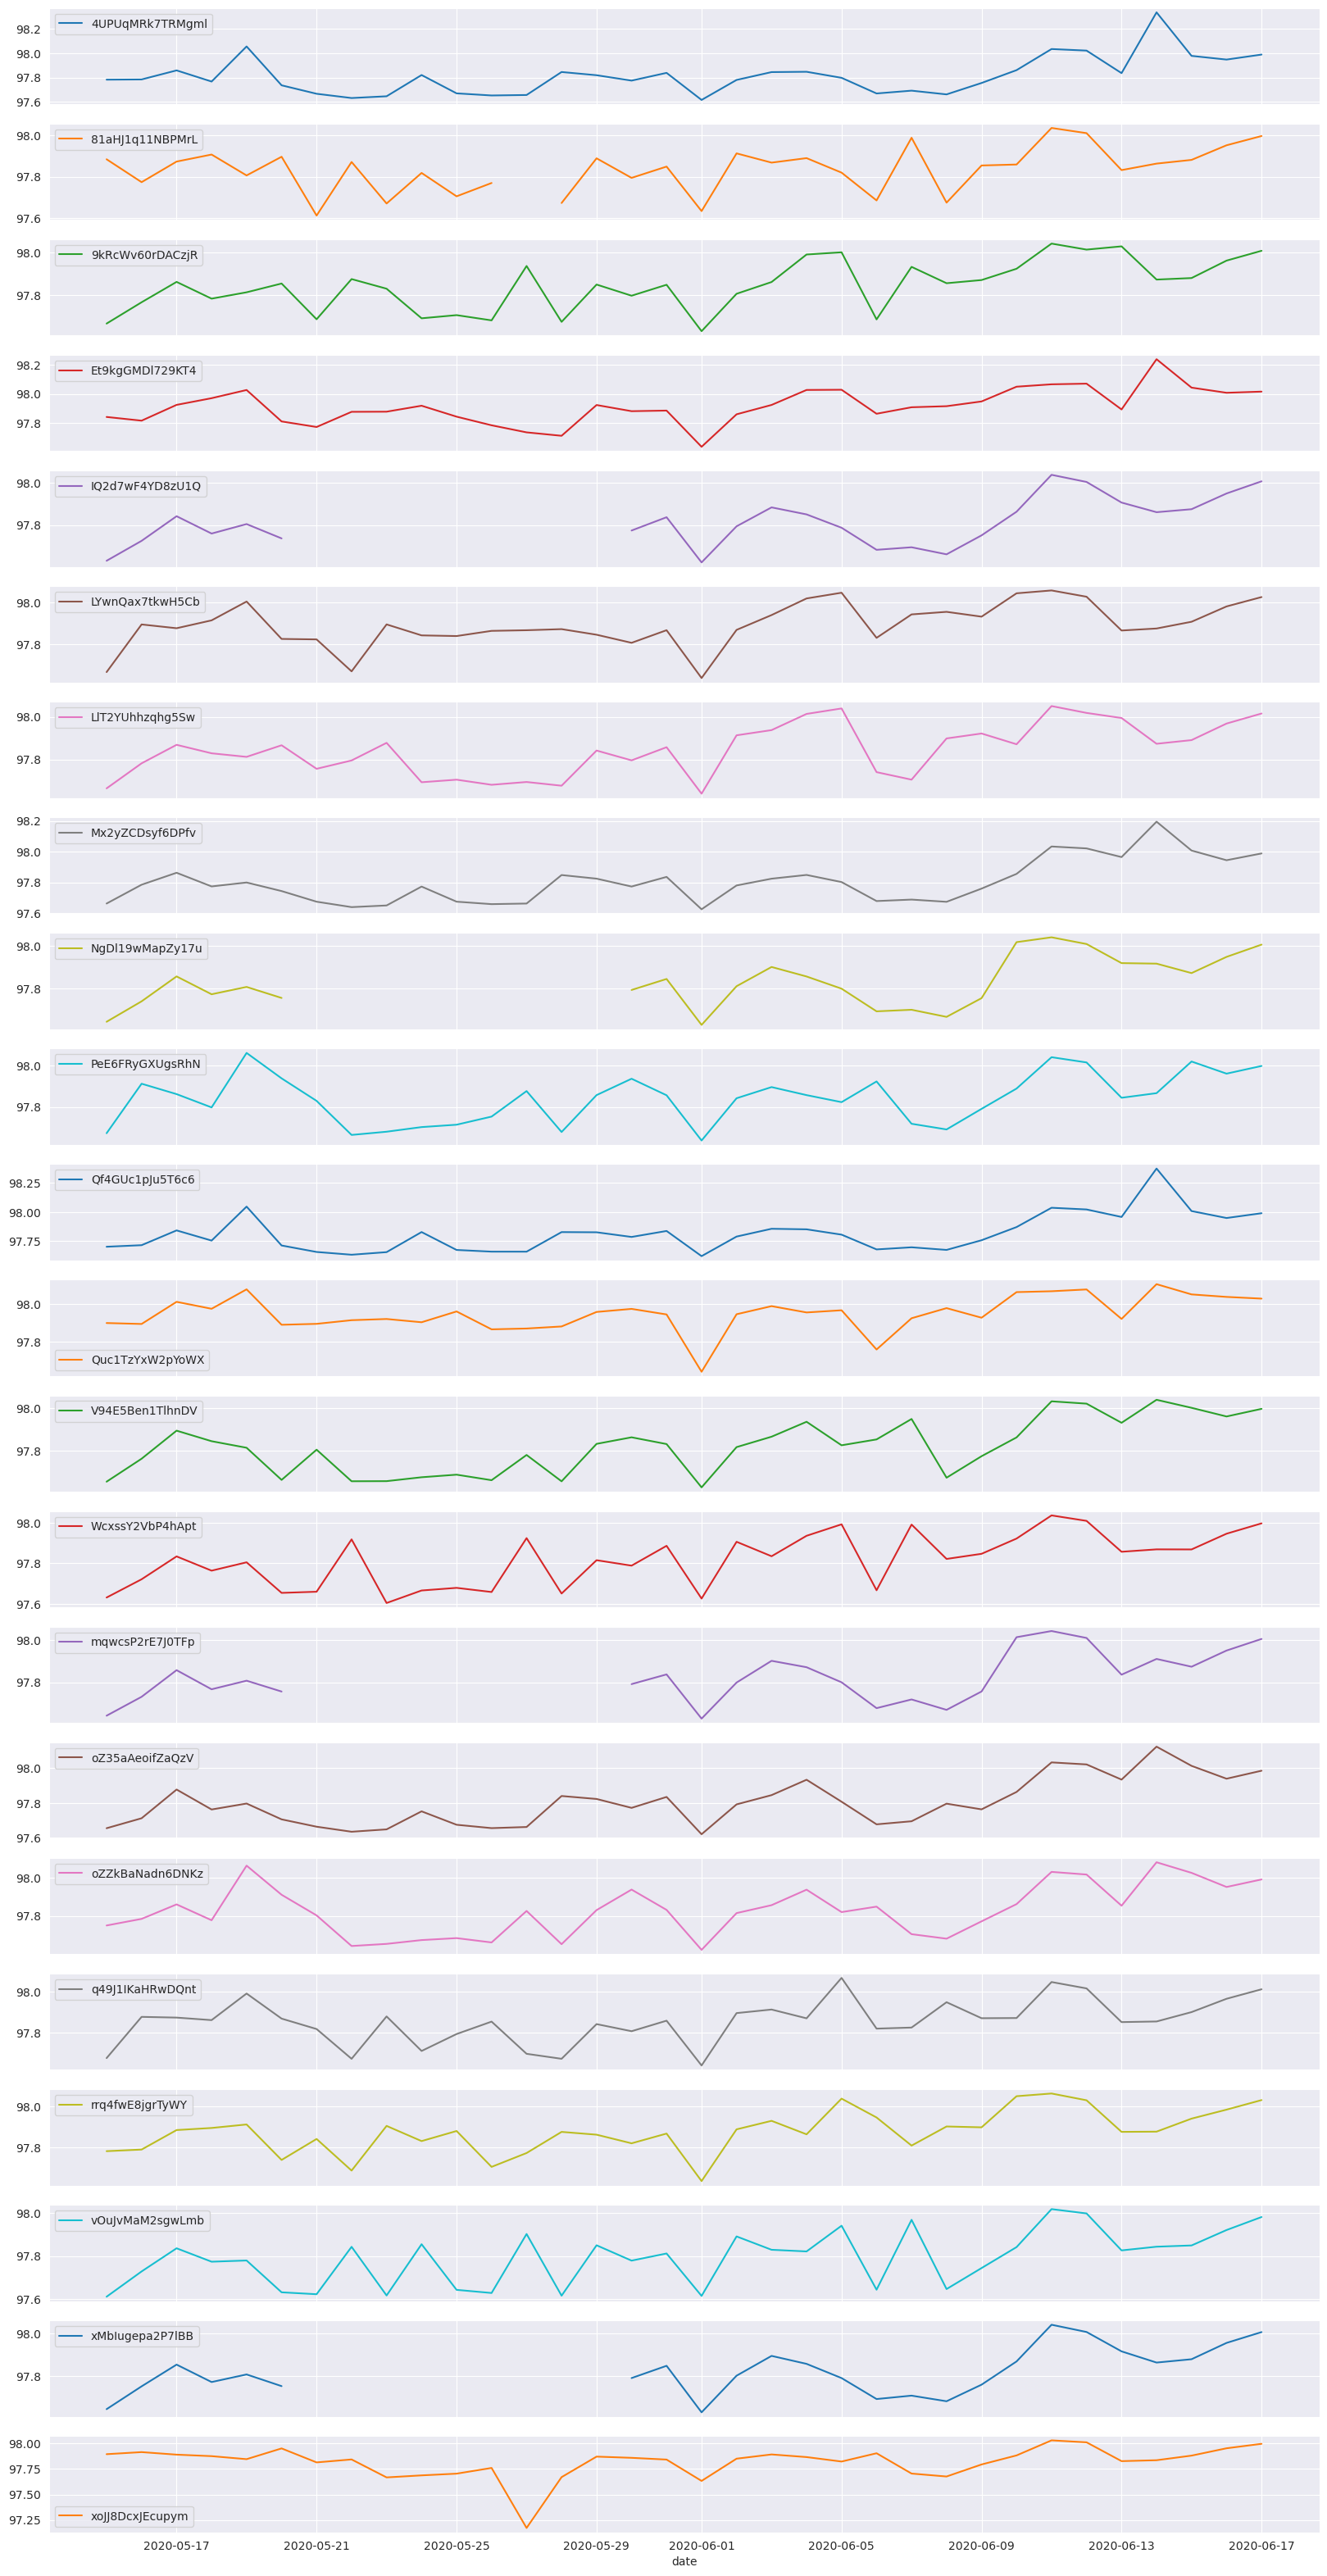

In [52]:
temp[temp.kw_dc > 0].groupby(['inverter_id','date']).inverter_efficiency.mean()\
    .unstack(level=0).plot(subplots=True, sharex=True, figsize=(20,40))
plt.show()

To have a comparison term we are going to repeat the analyzes with plant 1.

In [53]:
temp = df[df.plant == 'p1'].between_time('08:00:00','15:00:00')
temp['kw_dc_zero'] = np.where(temp.kw_dc == 0, 1, 0)
temp

plant  month  day  hour  minute        sensor_id  \
date_time                                                              
2020-05-15 08:00:00    p1      5   15     8       0  HmiyD2TTLFNqkNe   
2020-05-15 08:00:00    p1      5   15     8       0  HmiyD2TTLFNqkNe   
2020-05-15 08:00:00    p1      5   15     8       0  HmiyD2TTLFNqkNe   
2020-05-15 08:00:00    p1      5   15     8       0  HmiyD2TTLFNqkNe   
2020-05-15 08:00:00    p1      5   15     8       0  HmiyD2TTLFNqkNe   
...                   ...    ...  ...   ...     ...              ...   
2020-06-17 15:00:00    p1      6   17    15       0  HmiyD2TTLFNqkNe   
2020-06-17 15:00:00    p1      6   17    15       0  HmiyD2TTLFNqkNe   
2020-06-17 15:00:00    p1      6   17    15       0  HmiyD2TTLFNqkNe   
2020-06-17 15:00:00    p1      6   17    15       0  HmiyD2TTLFNqkNe   
2020-06-17 15:00:00    p1      6   17    15       0  HmiyD2TTLFNqkNe   

                        irradiation  ambient_temperature  module_temperature  \
date_time                                                                      
2020-05-15 08:00:00            0.20                25.42               31.41   
2020-05-15 08:00:00            0.20                25.42               31.41   
2020-05-15 08:00:00            0.20                25.42               31.41   
2020-05-15 08:00:00            0.20                25.42               31.41   
2020-05-15 08:00:00            0.20                25.42               31.41   
...                             ...                  ...                 ...   
2020-06-17 15:00:00            0.32                28.62               39.95   
2020-06-17 15:00:00            0.32                28.62               39.95   
2020-06-17 15:00:00            0.32                28.62               39.95   
2020-06-17 15:00:00            0.32                28.62               39.95   
2020-06-17 15:00:00            0.32                28.62               39.95   

                         inverter_id           kw_dc           kw_ac  \
date_time                                                              
2020-05-15 08:00:00  1BY6WEcLGh8j5v7         3246.00          318.67   
2020-05-15 08:00:00  1IF53ai7Xc0U56Y         2805.62          275.46   
2020-05-15 08:00:00  3PZuoBAID5Wc2HD         2736.12          268.62   
2020-05-15 08:00:00  7JYdWkrLSPkdwr4         2741.50          269.15   
2020-05-15 08:00:00  McdE0feGgRqW7Ca         3208.88          315.05   
...                              ...             ...             ...   
2020-06-17 15:00:00  uHbuxQJl8lW7ozc         4719.62          462.89   
2020-06-17 15:00:00  wCURE6d3bPkepu2         5077.75          497.80   
2020-06-17 15:00:00  z9Y9gH1T5YWrNuG         5113.00          501.29   
2020-06-17 15:00:00  zBIq5rxdHJRwDNY         4675.38          458.61   
2020-06-17 15:00:00  zVJPv84UY57bAof         4853.75          475.96   

                     inverter_efficiency          kw_day        kw_total  \
date_time                                                                  
2020-05-15 08:00:00                 9.82          263.57      6259822.57   
2020-05-15 08:00:00                 9.82          292.50      6183937.50   
2020-05-15 08:00:00                 9.82          287.75      6988046.75   
2020-05-15 08:00:00                 9.82          281.00      7603241.00   
2020-05-15 08:00:00                 9.82          291.00      7159255.00   
...                                  ...             ...             ...   
2020-06-17 15:00:00                 9.81         5423.50      7286458.50   
2020-06-17 15:00:00                 9.80         5343.75      7028061.75   
2020-06-17 15:00:00                 9.80         5282.88      7250667.88   
2020-06-17 15:00:00                 9.81         5284.75      6582836.75   
2020-06-17 15:00:00                 9.81         5368.75      7362730.75   

                           date  kw_dc_zero  
date_time                                    
2020-05-15 08:00:00  202

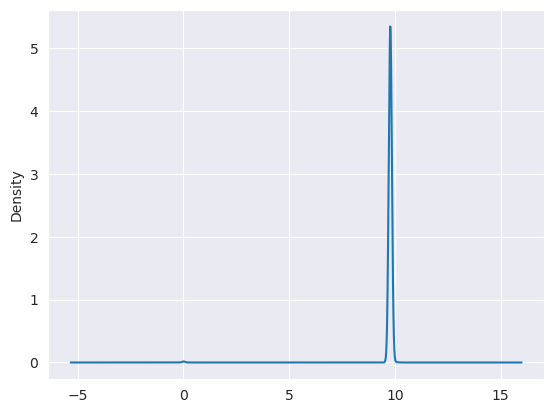

In [54]:
temp.inverter_efficiency.plot.density()
plt.show()

We see that no, here all the inverters have a constant efficiency (although very low)

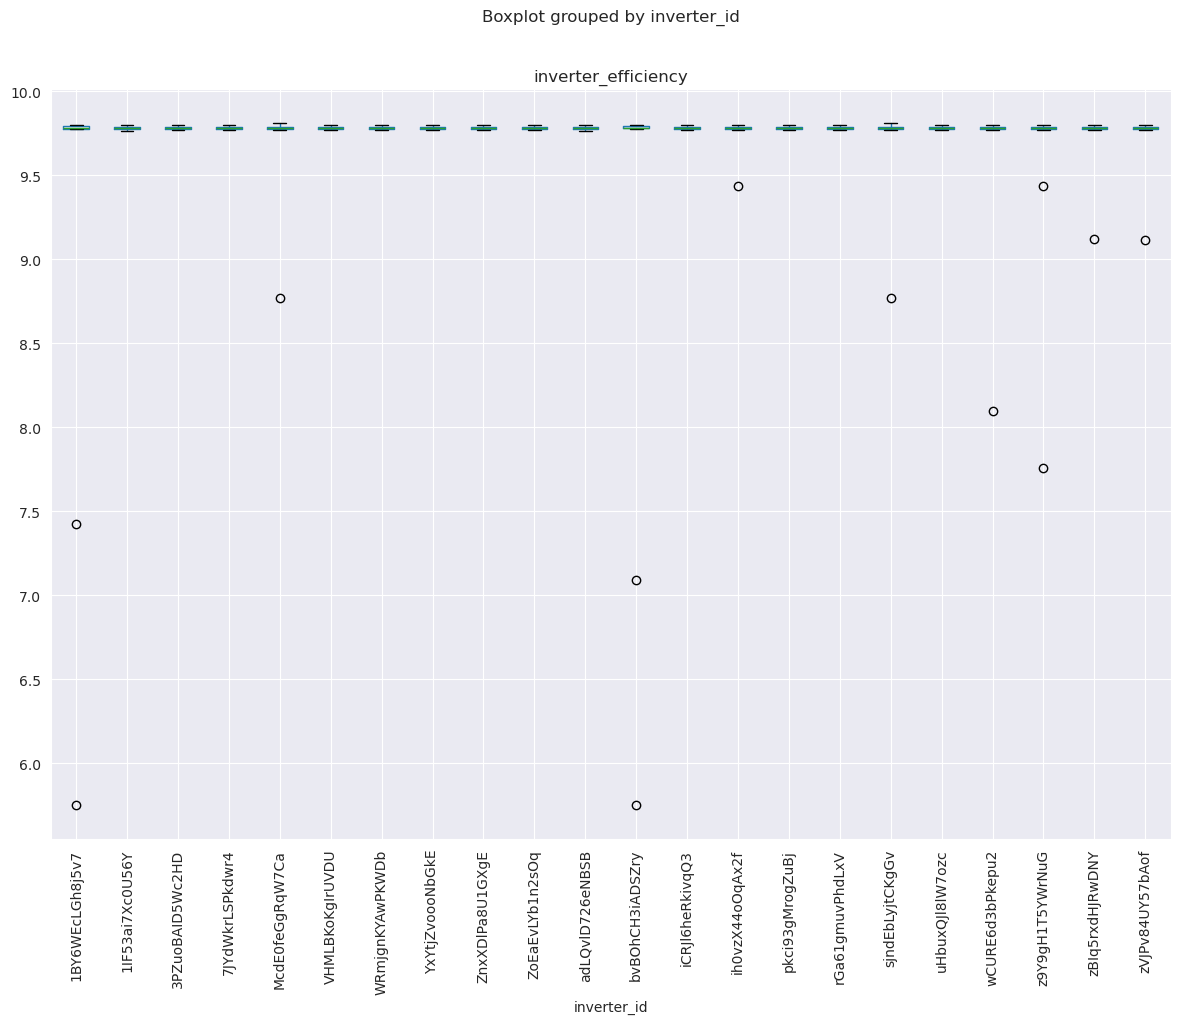

In [55]:
temp.groupby(['inverter_id', 'date'], as_index=False).inverter_efficiency.mean()\
    .boxplot(column='inverter_efficiency', by='inverter_id', figsize=(14,10))
plt.xticks(rotation=90)
plt.show()

In the graph we can see that except for specific days, the efficiency of the inverters is constant.


Review the average daily efficiency for each inverter on plant 1.

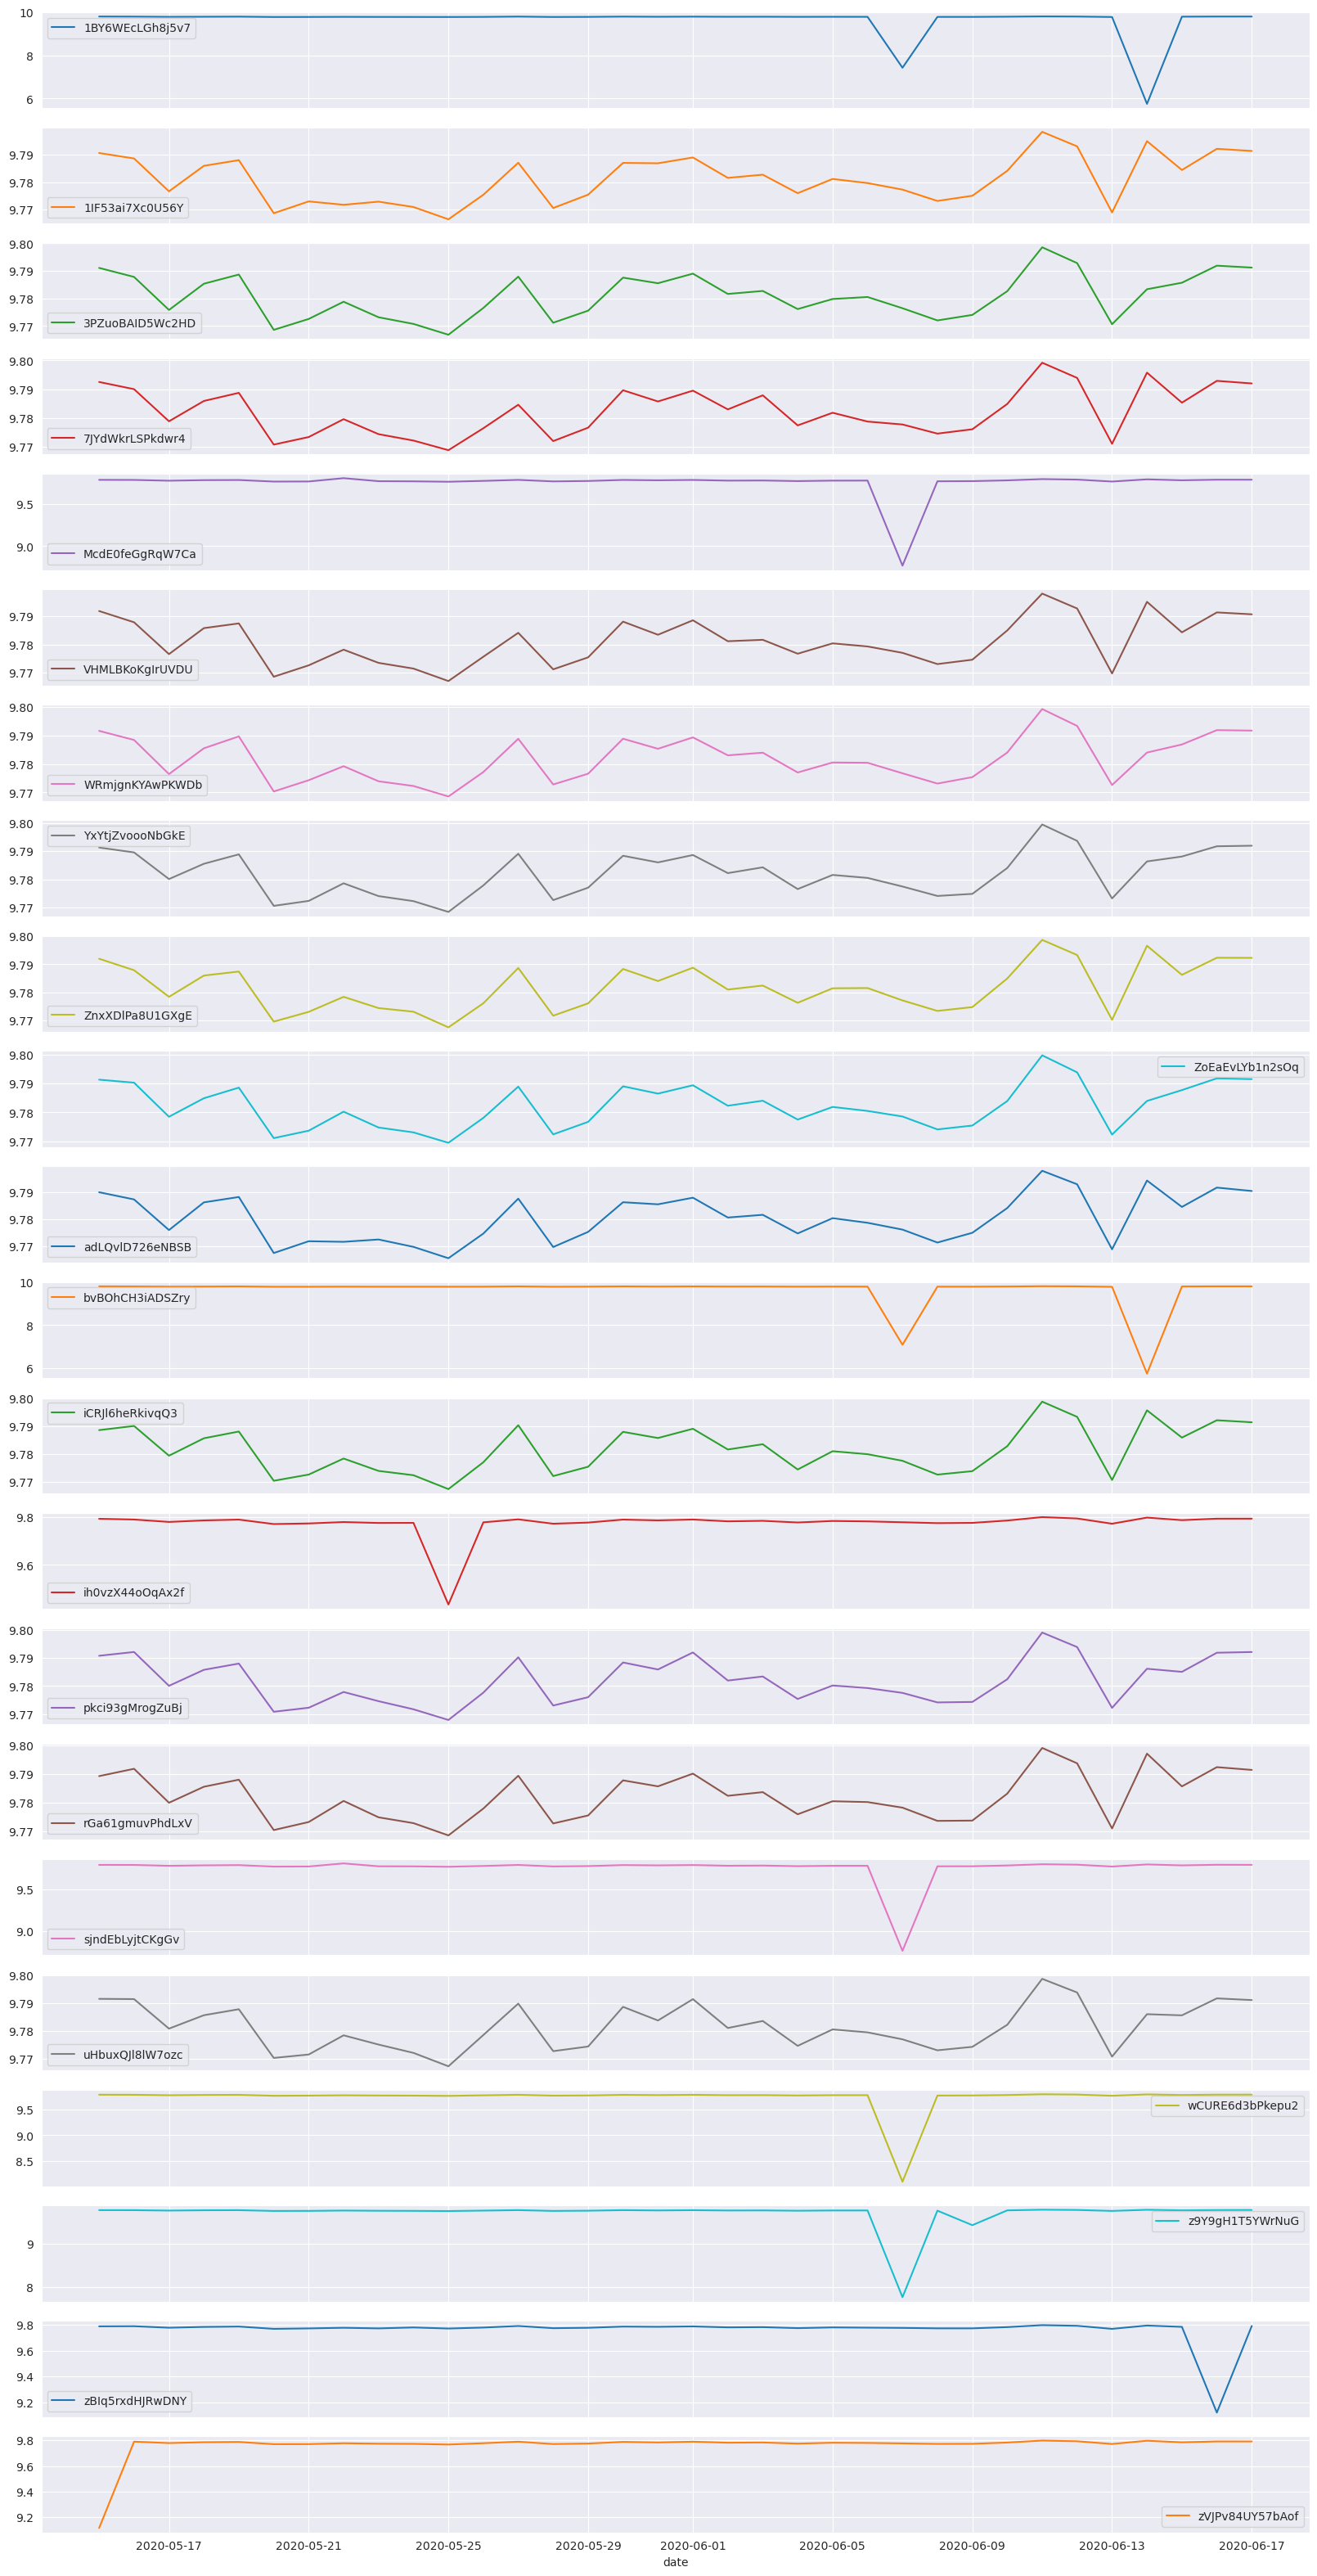

In [56]:
temp.groupby(['inverter_id','date'])['inverter_efficiency'].mean().unstack(level=0)\
    .plot(subplots=True, sharex=True, figsize=(20,40))
plt.show()

Inverter analysis indicates that all data are constant.

Check that there are no errors in DC generation.

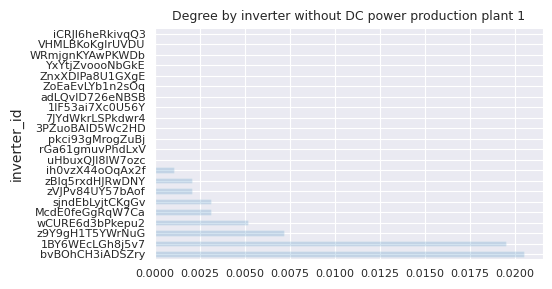

In [57]:
temp.groupby('inverter_id').kw_dc_zero.mean().sort_values(ascending=False)\
    .plot.barh(alpha=0.2, figsize=(5,3))
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.title('Degree by inverter without DC power production plant 1', fontsize=9)
plt.show()

We see that although there are some inverters that have had failures, their magnitude is less than 2% of the measurements.

Therefore, the generation of DC in plant 1 is correct, and the failure is in the transformation from DC to AC.

### Communication of results

After analyzing the data we can conclude that:
    
* There are serious data quality problems. It should be reviewed where in the chain these problems are generated, including the plant meters.
* The fact that DC generation is about 10 times higher in plant 1 than in plant 2, added to the fact that the efficiency in plant 1 is over 10% leads us to think that the DC generation data in plant 1 may be artificially scaled for some reason.
* But for now, in the absence of verification, we are going to assume that the data is correct.
* The two plants have received high amounts of irradiation, we have not located any problems in this phase.
* Although the ambient temperature is higher on plant 2 and its modules get hotter than those on plant 1, this does not seem to have a significant impact.
* The DC generation from plant 1 works well, the modules seem to carry DC to the inverters.
* The DC generation of plant 2 does NOT work well, some modules bring very little DC to the inverters even in the hours of greatest irradiation.
* The transformation from DC to AC on plant 1 does NOT work well, it only transforms around 10%, but constantly. And this low efficiency is not due to moments of non-reception of DC nor is it concentrated in specific inverters, but rather it seems more structural (again, keep in mind that it could be due to a data quality problem in kw_dc on plant 1).
* The DC to AC transformation of plant 2 works well, since once the zero DC generation periods are eliminated, the rest have an efficiency greater than 97%.

Recommendations:

* Review data collection and its reliability
* Maintenance review of the inverter modules on plant 2 in which there are many moments of zero DC generation
* Maintenance check of the inverters on Plant 1

We are going to generate an [**business presentation**](./DetectionInefficienciesSolarPlant.pdf) with the main conclusions and some recommendations for management.

**ACC**

S2!